This notebook will outline the pipeline for creating ground-truth object annotations for simulated coadds from the Vera C. Rubin Observatory Legacy Survey of Space and Time (LSST) [Data Challenge 2 (DC2) simulation](https://arxiv.org/pdf/2010.05926). We obtain this data from finding the overlapping areas of the 16 tiles we created in `roman_cutouts` with the LSST DC2 catalog. More info about the details of finding the overlapping data can be found in the `LSST_Roman_Cutouts`.

The core of this pipeline is a **simulation-based annotation** process. We use the DC2 truth catalogs containing the intrinsic physical properties of the simulated stars and galaxies. For each object in the truth catalog, we use **GalSim** to generate a noiseless, and isolated image. The ground-truth segmentation masks and bounding boxes are then derived from this simulation. The final outputs are formatted for use with [DeepDISC](https://github.com/grantmerz/deepdisc).

# Available Data Products

The full pipeline generates the following data products:

  * **COCO-Style Annotations**: A `.json` file for each tile containing object annotations (segmentation masks, bounding boxes) for all successfully processed objects within that tile, formatted for DeepDISC training.
  * **Rejected Object Logs**: A companion `.json` file for each tile that logs all objects that failed the annotation process, including the reason for rejection and a path to the generated mask (`.npy`) if available.

-----

# File Structure

The project's data is organized into a clear directory structure:

```
/pscratch/sd/y/yaswante/MyQuota/roman_lsst/

├── lsst_data/truth/  (contains LSST data)
│   └── dc2_{tile_name}/
│       ├── full_c{cutout_id}_{tile_name}.npy
│       ├── truth_c{cutout_id}_{tile_name}.json
│       ├── det_c{cutout_id}_{tile_name}.json
│       └── wcs_{tile_name}.json
│
├── lsst_data/truth-ups/  (contains upsampled LSST data)
│   └── dc2_{tile_name}/
│       ├── full_c{cutout_id}_{tile_name}.npy
│       └── ... (and corresponding catalogs)
│
└── lsst_data/
    ├── truth/ (contains LSST data)
    │   └── dc2_{tile_name}/
    │       ├── full_c{cutout_id}_{tile_name}.npy
    │       ├── truth_c{cutout_id}_{tile_name}.json
    │       ├── det_c{cutout_id}_{tile_name}.json
    │       └── wcs_{tile_name}.json
    │
    ├── truth-ups/  (contains upsampled LSST data)
    │   └── dc2_{tile_name}/
    │       ├── full_c{cutout_id}_{tile_name}.npy
    │       └── ... (and corresponding catalogs)
    │
    ├── annotations_lvl{SNR_lvl}/
    │   └── dc2_{tile_name}.json  (successful annotations)
    │
    └── rejected_objs_lvl{SNR_lvl}/
        ├── dc2_{tile_name}.json  (rejected object logs)
        └── rejected_masks/
            └── {tile_name}/
                └── c{cutout_id}/
                    └── mask_{obj_idx}.npy
```

  * The `truth` and `truth-ups` directories store the raw image and catalog cutouts generated by the `LSST_Roman_Cutouts` pipeline.
  * The `annotations` and `rejected_objs` directories will contain the final set of annotations and rejection logs.

-----

# Description of Data

## Input Data

  * **LSST DC2 Truth Catalogs**: The pipeline primarily uses `dc2_run2.2i_truth_merged_summary` for basic object properties and `cosmoDC2_v1.1.4_image` for detailed morphological information (e.g., bulge/disk sizes and ellipticities) needed by `galsim`.
  * **LSST Cutout Data**: The image cutouts (`.npy`) and their corresponding truth catalogs (`.json`) generated by the `LSST_Roman_Cutouts.md` notebook serve as the direct input for this annotation script.
  * **WCS Headers**: The `.json` files containing WCS headers are used to correctly map pixel coordinates to world coordinates (RA, Dec).

### Output Annotations & Schema

The successful annotations are saved in a COCO-compliant JSON format. Each file is a list of dictionaries, where each dictionary represents a single cutout image and contains its annotations.

  * **Image-level keys**:
      * `file_name`: Path to the LSST image cutout (`.npy` file).
      * `image_id`: The cutout ID (0-224).
      * `height`, `width`: Dimensions of the image cutout.
      * `tile`: The tile name (e.g., "53.25\_-41.8").
      * `wcs`: The WCS header string for the cutout.
      * `annotations`: A list of dictionaries, where each dictionary is an annotation for a single object.
  * **Object-level keys** (within the `annotations` list):
      * `obj_id`: Unique identifier from the original truth catalog.
      * `category_id`: `0` for galaxies, `1` for stars.
      * `bbox`: Bounding box in `[x, y, width, height]` format.
      * `bbox_mode`: Set to `1`, corresponding to `BoxMode.XYWH_ABS` in Detectron2.
      * `segmentation`: A list of polygon coordinates `[x1, y1, x2, y2, ...]` defining the object's mask.
      * `area`: The area of the bounding box.
      * `ra`, `dec`, `redshift`, `size_true`, magnitudes, and other physical properties from the truth catalog.

### Rejected Object Logs & Schema

Objects that fail the annotation process are saved to a separate log file with a similar structure.

  * **Image-level keys**: Same as the successful annotations.

  * **Object-level keys** (within the `rejected_objs` list):

      * Includes all physical properties of the object for later analysis.
      * `reason`: A string indicating why the object was rejected.
      * `mask_path`: A path to the saved `.npy` file of the generated (but invalid) mask. `None` if Galsim failed to produce any mask.

  * **Common Rejection Reasons**:

      * `empty_mask`: The generated segmentation mask has zero pixels after applying the SNR threshold across all bands.
      * `small_mask_12px`: The mask area is less than 12 pixels, which is too small to be reliable.
      * `invalid_contours`: `cv2.findContours` could not generate a valid polygon with at least 3 points from the mask.
      * `galsim_fail`: `galsim` failed to render the object, often due to extremely bright stars requiring excessive memory for FFT operations.

-----

# Timing

  * **Single-threaded**: Initial tests showed that processing a single cutout takes 8-10 seconds. Extrapolating to a full tile of 225 cutouts would take approximately **37.5 minutes**.
  * **Multiprocessing**: The task is "embarrassingly parallel." By using a pool of 64 CPU cores, the processing time for a full tile is reduced to **\~1-2 minutes**, a speedup of nearly 32x. For example, the `55.03_-41.9` tile was processed in just **74.65 seconds**.

-----

# Current Limitations

  * **Bright Star Failures**: The `galsim` simulation can fail for extremely bright stars. This is because the FFT required to render the object can exceed available memory. (eg. cutout 199 from `55.03_-41.9`)
  * **Annotation Incompleteness**: Objects that are extremely faint, small, or have erroneous catalog parameters may be rejected by the pipeline. The final annotated dataset is therefore a subset of the complete ground truth. The `rejected_objs` logs are essential for characterizing this selection effect.
  
-----

# Future Improvements

  * **Handle Bright Stars**: Implement a fallback mechanism for bright stars that cause `galsim` to fail. This could involve using an alternative drawing method for these specific cases.
  * **Blending Flags**: The pipeline could be extended to calculate and add a "blendedness" metric to each annotation by checking for overlapping masks with nearby objects.

# Imports

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
# change these paths to your specific directories where deepdisc and detectron2 are stored
sys.path.insert(0, '/home/yse2/deepdisc/src')
sys.path.insert(0, '/home/yse2/detectron2')

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import deepdisc
import detectron2
print(deepdisc.__file__)
print(detectron2.__file__)
from detectron2.data import MetadataCatalog, DatasetCatalog

# Standard imports
import os, json, random, glob
import numpy as np
import pandas as pd
import time
import scarlet
import cv2
import argparse
import re
import sep
# for multiprocessing
import multiprocessing

# astropy
import astropy.io.fits as fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.table import Table
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats
from astropy.visualization import make_lupton_rgb

# Astrodet imports
from deepdisc.astrodet.visualizer import Visualizer, ColorMode


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

import galsim
import btk

/home/yse2/deepdisc/src/deepdisc/__init__.py
/home/yse2/detectron2/detectron2/__init__.py


In [9]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+g11d1363
1.23.4
1.2.1


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from astropy.visualization import AsinhStretch, MinMaxInterval, ImageNormalize
def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))

def stretch_color(data, clipPercent):
    return np.percentile(data, (0 + clipPercent, 100 - clipPercent))

# Exploring the Available LSST Data and Catalogs

Insert brief description of 16 tiles available, 225 cutouts but some of them are empty because they had multiple patches/tracts.

In [5]:
class LSSTCutout:
    """Tool for randomly selecting and plotting cutouts from the processed data"""
    
    def __init__(
        self,
        root_dir,
        lsst_dir,
        lsst_ups_dir,
        roman_dir,
        all_tiles,
        cutouts_per_tile
    ):
        self.root_dir = root_dir
        self.lsst_dir = lsst_dir
        self.lsst_ups_dir = lsst_ups_dir
        self.roman_dir = roman_dir
        self.all_tiles = all_tiles
        self.cutouts_per_tile = cutouts_per_tile
        
    def load_cutout(self, tile, cutout_id):
        """Load all data for a specific cutout"""
        base_filename = f'c{cutout_id}_{tile}'
        paths = {
            'lsst_img': f'{self.lsst_dir}dc2_{tile}/full_{base_filename}.npy',
            'lsst_ups_img': f'{self.lsst_ups_dir}dc2_{tile}/full_{base_filename}.npy',
            'roman_img': f'{self.roman_dir}{tile}/full_{base_filename}.npy',
            'truth_cat': f'{self.lsst_dir}dc2_{tile}/truth_{base_filename}.json',
            'det_cat': f'{self.lsst_dir}dc2_{tile}/det_{base_filename}.json',
            'truth_cat_ups': f'{self.lsst_ups_dir}dc2_{tile}/truth_{base_filename}.json',
            'det_cat_ups': f'{self.lsst_ups_dir}dc2_{tile}/det_{base_filename}.json',
            'roman_det': f'{self.roman_dir}{tile}/det_{base_filename}.json',
            'roman_truth': f'{self.roman_dir}{tile}/truth_{base_filename}.json'
        }

        if not os.path.exists(paths['lsst_img']):
            print(f"Cutout {cutout_id} from tile {tile} does not exist!")
            return None

        try:
            lsst_img = np.load(paths['lsst_img'])
            lsst_ups_img = np.load(paths['lsst_ups_img'])
            roman_img = np.load(paths['roman_img'])

            is_empty = lsst_img.shape == (6, 0, 0)
            is_empty_roman = roman_img.shape == (4, 0, 0)

            truth_cat = pd.read_json(paths['truth_cat']) if os.path.exists(paths['truth_cat']) else pd.DataFrame()
            det_cat = pd.read_json(paths['det_cat']) if os.path.exists(paths['det_cat']) else pd.DataFrame()
            truth_cat_ups = pd.read_json(paths['truth_cat_ups']) if os.path.exists(paths['truth_cat_ups']) else pd.DataFrame()
            det_cat_ups = pd.read_json(paths['det_cat_ups']) if os.path.exists(paths['det_cat_ups']) else pd.DataFrame()

            roman_truth = None
            if os.path.exists(paths['roman_truth']):
                roman_truth = pd.read_json(paths['roman_truth'])
                roman_det = pd.read_json(paths['roman_det'])

            return {
                'tile': tile,
                'cutout_id': cutout_id,
                'lsst_img': lsst_img,
                'lsst_ups_img': lsst_ups_img,
                'roman_img': roman_img,
                'truth_cat': truth_cat,
                'det_cat': det_cat,
                'truth_cat_ups': truth_cat_ups,
                'det_cat_ups': det_cat_ups,
                'roman_truth': roman_truth,
                'roman_det': roman_det,
                'is_empty': is_empty,
                'is_empty_roman': is_empty_roman,
                'paths': paths
            }

        except Exception as e:
            print(f"Error loading cutout {cutout_id} from tile {tile}: {e}")
            return None
    def get_random_cutout(self, tile=None, cutout_id=None, exclude_empty=True):
        """
        Get a random cutout. Can specify tile and/or cutout_id.

        Parameters:
        -----------
        tile : str, optional
            Specific tile to use. If None, randomly selects one.
        cutout_id : int, optional
            Specific cutout ID to use. If None, randomly selects one.
        exclude_empty : bool, default True
            If True, will retry until finding a non-empty cutout.

        Returns:
        --------
        dict : Dictionary containing all loaded data and metadata
        """

        attempts = 0
        cutouts_per_tile = 225
        max_attempts = 50 if exclude_empty else 1

        while attempts < max_attempts:
            if tile is None:
                selected_tile = random.choice(self.all_tiles)
            else:
                selected_tile = tile

            if cutout_id is None:
                selected_cutout_id = random.randint(0, self.cutouts_per_tile - 1)
            else:
                selected_cutout_id = cutout_id

            result = self.load_cutout(selected_tile, selected_cutout_id)
#             print(result)

            if result is not None:
                if not exclude_empty or (not result['is_empty'] and not result['is_empty_roman']):
                    return result

            attempts += 1

            # If specific tile/cutout was requested, we don't retry w/ diff ones
            if tile is not None or cutout_id is not None:
                break

        print(f"Could not find a valid cutout after {attempts} attempts")
        return None
    
    def plot_cutout(self, data, band='i', figsize=(12, 12)):
        """Plot a cutout using asinh visualization"""
        
        if data['is_empty']:
            print(f"Cutout {data['cutout_id']} from tile {data['tile']} is empty (was skipped during processing)")
            return
            
        band_indices = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
        band_idx = band_indices.get(band, 3)
        
#         fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(2, 2, figure=fig)
        axes = {}
        axes['lsst'] = fig.add_subplot(gs[0, 0])
        axes['lsst_ups'] = fig.add_subplot(gs[0, 1])
        axes['roman'] = fig.add_subplot(gs[1, :])
        # OG LSST image
        lsst_band_img = data['lsst_img'][band_idx, :, :]
        axes['lsst'].set_title(f"LSST - ${band}$ Band (Tile: {data['tile']}, Cutout: {data['cutout_id']})")
        axes['lsst'].imshow(lsst_band_img, norm=asinh_norm(lsst_band_img, a=0.1), origin='lower', cmap='viridis')
        
        if not data['truth_cat'].empty:
            gt1 = axes['lsst'].scatter(data['truth_cat']['cutout_x'], data['truth_cat']['cutout_y'], 
                          color='red', s=8, label='Ground Truth')
        if not data['det_cat'].empty:
            det1 = axes['lsst'].scatter(data['det_cat']['cutout_x'], data['det_cat']['cutout_y'], 
                          marker='x', color='black', label='LSST Detected')
        
        # Upsampled LSST image
        upsampled_band_img = data['lsst_ups_img'][band_idx, :, :]
        axes['lsst_ups'].set_title(f"LSST Upsampled - ${band}$ Band")
        axes['lsst_ups'].imshow(upsampled_band_img, norm=asinh_norm(upsampled_band_img, a=0.1), 
                      origin='lower', cmap='viridis')
        
        if not data['truth_cat_ups'].empty:
            axes['lsst_ups'].scatter(data['truth_cat_ups']['cutout_x'], data['truth_cat_ups']['cutout_y'], 
                          color='red', s=8, label='Ground Truth')
        if not data['det_cat_ups'].empty:
            axes['lsst_ups'].scatter(data['det_cat_ups']['cutout_x'], data['det_cat_ups']['cutout_y'], 
                          marker='x', color='black', label='LSST Detected')
        # roman
        roman_img = data['roman_img'][0, :, :]
        axes['roman'].set_title(f"Roman - F184 Band")
        axes['roman'].imshow(roman_img, clim=stretch_color(roman_img, 1), 
                          origin='lower', cmap='viridis')
        
        if not data['roman_truth'].empty:
            gt2 = axes['roman'].scatter(data['roman_truth']['cutout_x'], data['roman_truth']['cutout_y'], 
                          color='red', s=8, label='Ground Truth')
        if not data['roman_det'].empty:
            det2 = axes['roman'].scatter(data['roman_det']['cutout_x'], data['roman_det']['cutout_y'], 
                          marker='x', color='black', label='Roman Detected')        
        
        fig.legend(handles=[gt1, det1], 
                   loc='upper center', 
                   bbox_to_anchor=(0.5, 1.03),
                   ncol=2)

        plt.tight_layout()

In [6]:
root_dir = './lsst_data/' # '/work/hdd/bdsp/yse2/lsst_data/'
lsst_dir = f'{root_dir}truth/'
lsst_ups_dir = f'{root_dir}truth-ups/'
roman_dir = f'./roman_data/truth/' # f'/work/hdd/bdsp/yse2/truth-roman/'
all_tiles = [
    "50.93_-38.8", "50.93_-42.0", "51.34_-41.3", "51.37_-38.3", 
    "51.53_-40.0", "52.31_-41.6", "52.40_-41.1", "52.49_-39.1", 
    "52.93_-40.8", "53.25_-41.8", "53.75_-38.9", "54.24_-38.3", 
    "54.31_-41.6", "55.03_-41.9", "55.54_-41.9", "56.06_-39.8"
]

cutout = LSSTCutout(
    root_dir=root_dir,
    lsst_dir=lsst_dir,
    lsst_ups_dir=lsst_ups_dir,
    roman_dir=roman_dir,
    all_tiles=all_tiles,
    cutouts_per_tile=225
)

In [ ]:
data = cutout.get_random_cutout()
if data:
    cutout.plot_cutout(data)

<a href="assets/random_cutout_plot.png">
  <img src="assets/random_cutout_plot.png" alt="Random LSST Cutout from the Tiles" width="900">
</a>

In [ ]:
# ra_dec_dir = '51.53_-40.0'
# cutout_id = 90 
data = cutout.get_random_cutout(tile='51.53_-40.0', cutout_id=90)
if data:
    cutout.plot_cutout(data)

<a href="assets/cutout_90_plot.png">
  <img src="assets/cutout_90_plot.png" alt="LSST Cutout 90 from the Tile: 51.53_-40.0" width="900">
</a>

In [11]:
def interactive():
    cutout = LSSTCutout()
    while True:
        print("\n" + "="*60)
        print("Cutout Verification Tool")
        print("="*60)
        print("1. Random cutout")
        print("2. Specific cutout")
        print("3. Random cutout from specific tile")
        print("4. Exit")

        choice = input("\nEnter choice (1-4): ")

        if choice == '1':
            data = cutout.get_random_cutout(exclude_empty=True)
            if data:
                cutout.plot_cutout(data)

        elif choice == '2':
            tile = input("Enter tile (e.g., 51.53_-40.0): ")
            cutout_id = int(input("Enter cutout ID (0-224): "))
            data = cutout.load_cutout(tile, cutout_id)
            if data:
                if not data['is_empty']:
                    cutout.plot_cutout(data)

        elif choice == '3':
            print("\nAvailable tiles:")
            for i, tile in enumerate(verifier.all_tiles):
                print(f"  {i}: {tile}")
            tile_idx = int(input("Enter tile index: "))
            tile = cutout.all_tiles[tile_idx]
            data = cutout.get_random_cutout(tile=tile, exclude_empty=True)
            if data:
                cutout.plot_cutout(data)

        elif choice == '4':
            break

        else:
            print("Invalid choice")


Cutout Verification Tool
1. Random cutout
2. Specific cutout
3. Random cutout from specific tile
4. Exit



Enter choice (1-4):  1



Cutout Verification Tool
1. Random cutout
2. Specific cutout
3. Random cutout from specific tile
4. Exit



Enter choice (1-4):  4


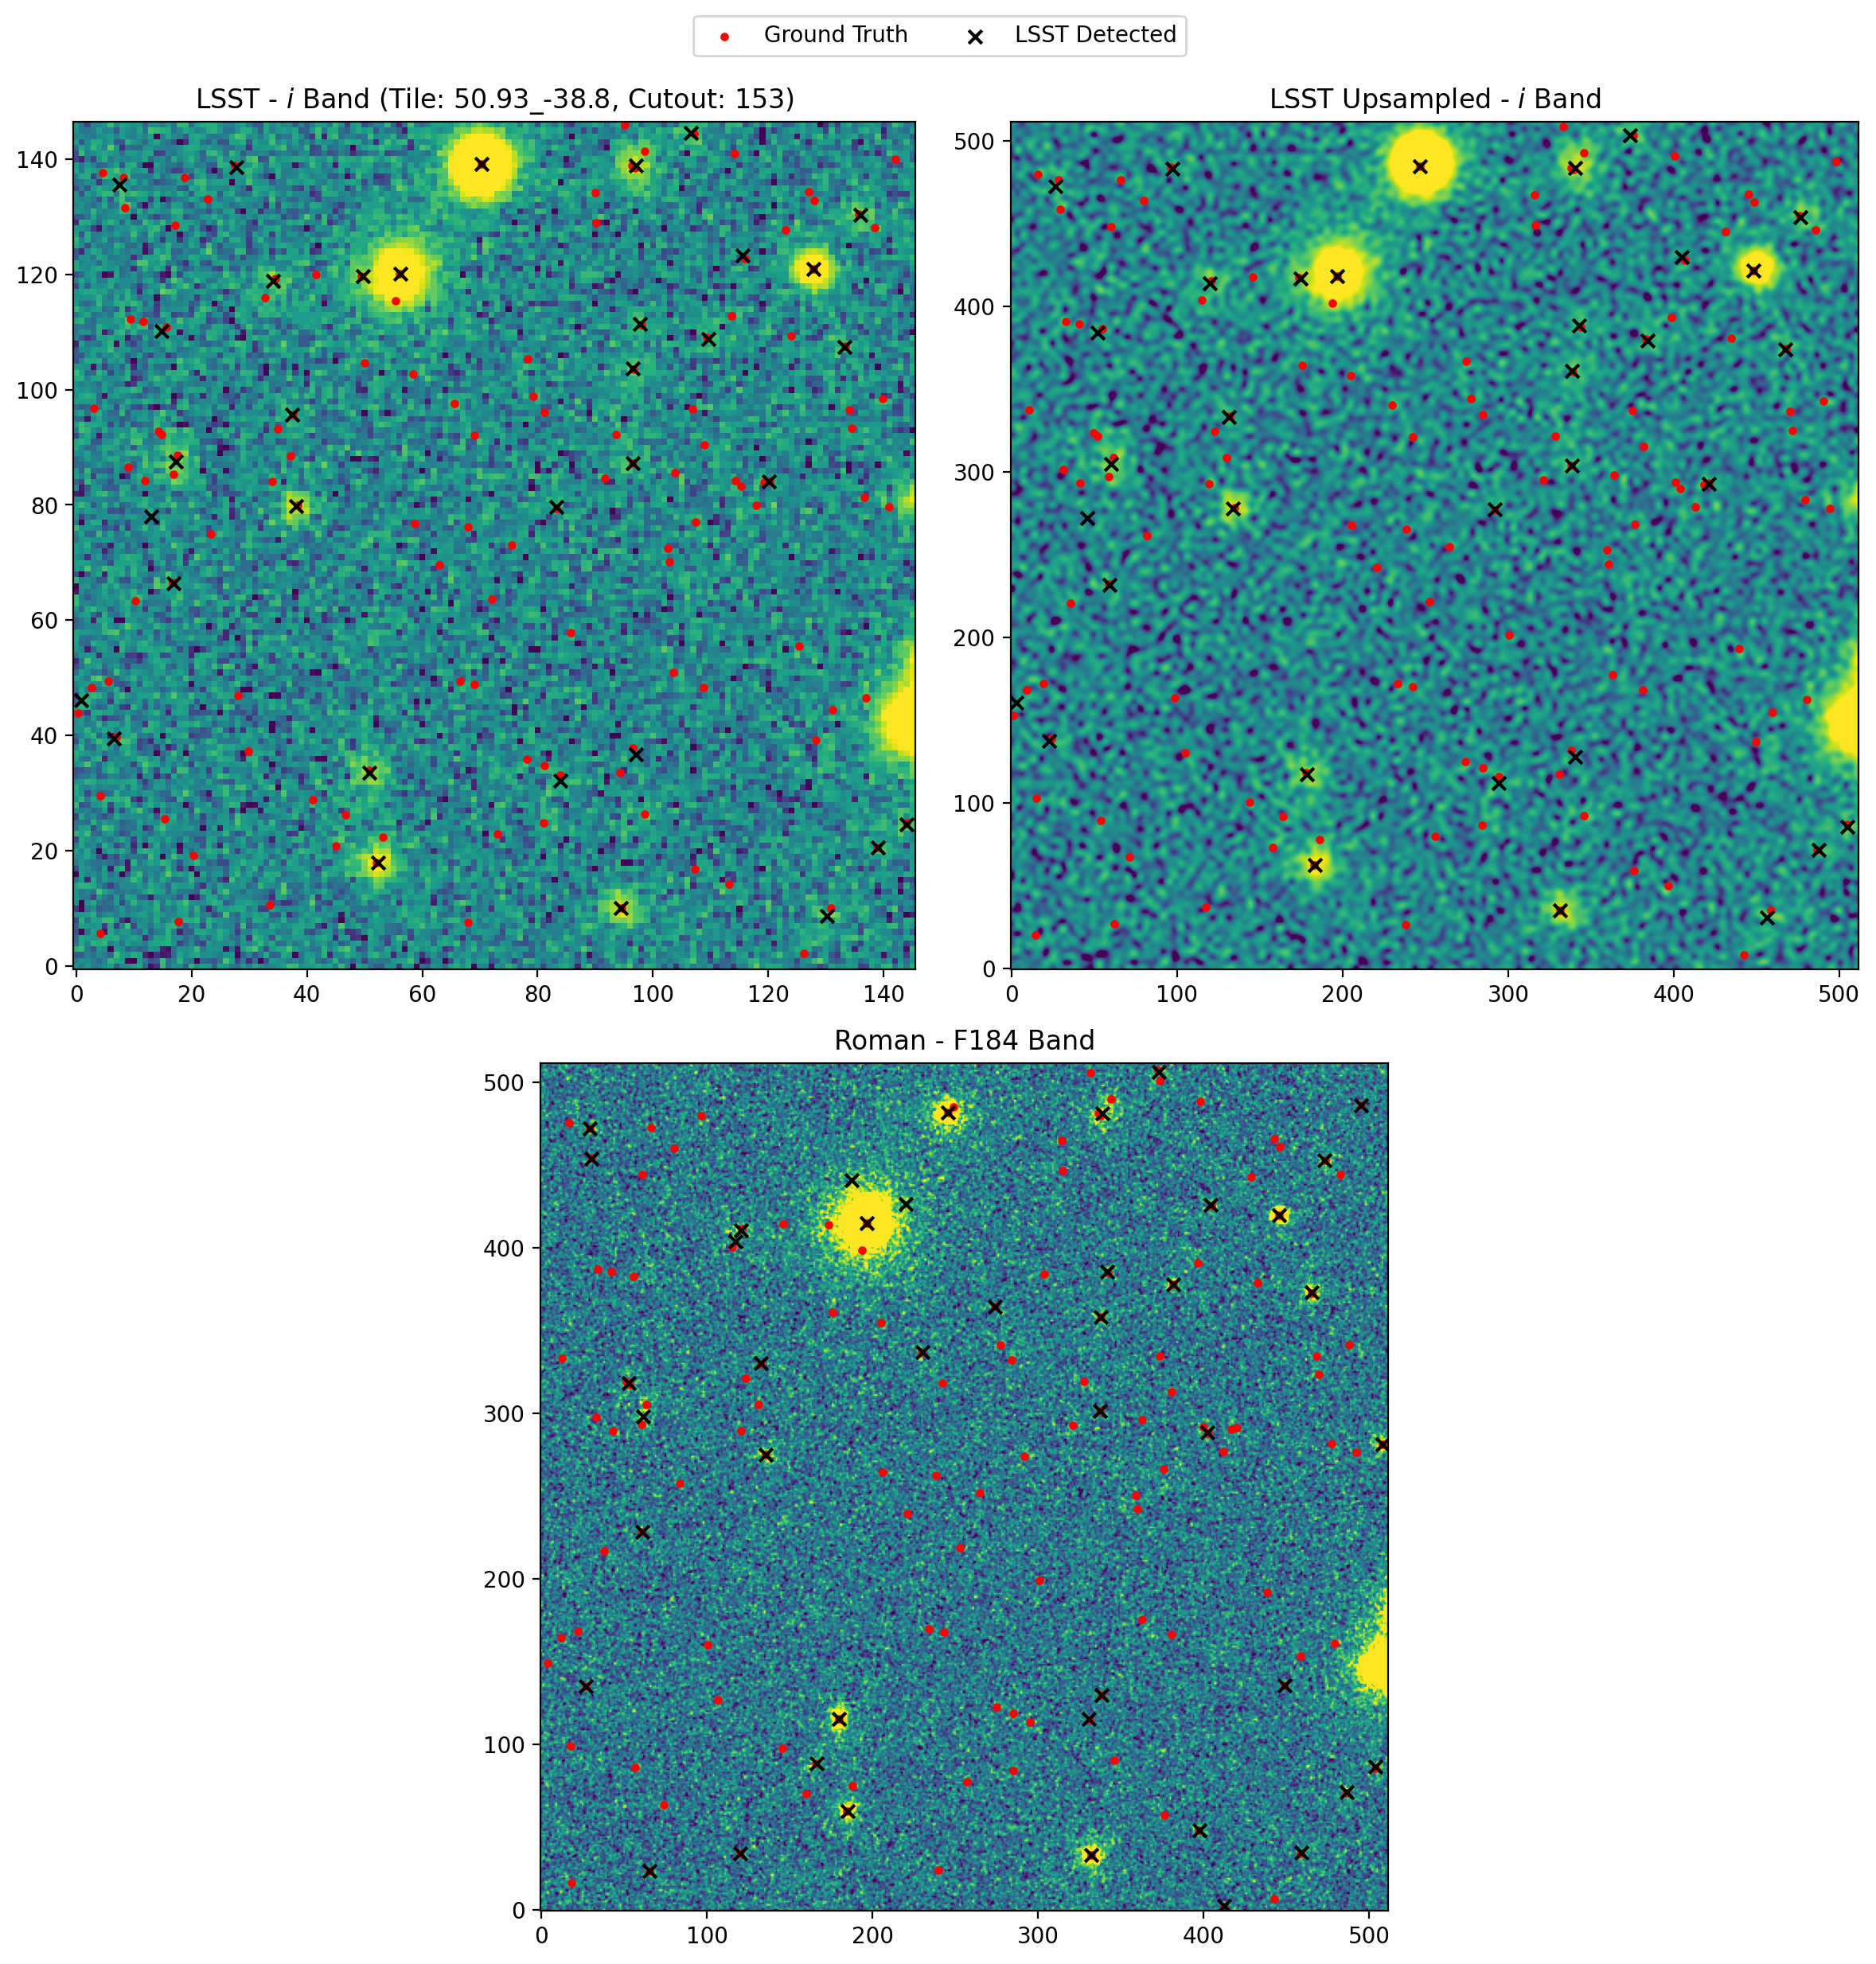

In [53]:
interactive()

# Annotation Generation with Galsim

## Helper Functions

In [12]:
seed = 8312
rng = np.random.RandomState(seed)
grng = galsim.BaseDeviate(rng.randint(0, 2**30))

def e1e2_to_ephi(e1,e2):
    pa = np.arctan(e2/e1)
    return pa

def dcut_reformat(cat):
    L0 = 3.0128e28
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        cat[f'{band}_ab'] = cat[f'mag_true_{band}']
        total_flux = L0 * 10**(-0.4*cat[f'mag_true_{band}']) # physical flux
        bulge_to_total_ratio = cat[f'bulge_to_total_ratio_{band}']

        cat[f'fluxnorm_bulge_{band}'] = total_flux * bulge_to_total_ratio
        cat[f'fluxnorm_disk_{band}'] = total_flux * (1-bulge_to_total_ratio)
        cat[f'fluxnorm_agn_{band}'] = np.zeros(total_flux.shape)

    cat['a_b'] = cat['size_bulge_true']
    cat['b_b'] = cat['size_minor_bulge_true']

    cat['a_d'] = cat['size_disk_true']
    cat['b_d'] = cat['size_minor_disk_true']
    # pos angle
    cat['pa_bulge'] = e1e2_to_ephi(cat['ellipticity_1_bulge_true'],cat['ellipticity_2_bulge_true']) * 180.0/np.pi

    cat['pa_disk'] = e1e2_to_ephi(cat['ellipticity_1_disk_true'],cat['ellipticity_2_disk_true']) * 180.0/np.pi
    
    cat['pa_tot'] = e1e2_to_ephi(cat['ellipticity_1_true'],cat['ellipticity_2_true']) * 180.0/np.pi

    cat['g1'] = cat['shear_1']
    cat['g2'] = cat['shear_2']
    
    return cat

## Making Star and Galaxy Images Functions

In [13]:
class SourceNotVisible(Exception):
    """Custom exception for objects with zero flux"""
    pass

def get_star_gsparams(mag, flux, noise):
    """
    Gets appropriate GSParams for a star given flux and noise

    Parameters
    ----------
    mag : float
        mag of star
    flux : float
        flux of star in electrons
    noise : float
        Mean sky background level in electrons. In background-limited
        scenarios, this value serves as a proxy for the noise variance
        (i.e., noise_rms^2) and is used to set Fourier-space accuracy parameters

    Returns
    -------
    galsim.GSParams or None
        An appropriate GSParams object for the star, or None if the star is
        not bright enough to require special handling
    bool
        A boolean flag, `isbright`, which is True if mag < 18
    """
    do_thresh = do_acc = False
    if mag < 18:
        do_thresh = True
    if mag < 15:
        do_acc = True

    if do_thresh or do_acc:
        isbright = True

        kw = {}
        if do_thresh:

            # this is designed to quantize the folding_threshold values,
            # so that there are fewer objects in the GalSim C++ cache.
            # With continuous values of folding_threshold, there would be
            # a moderately largish overhead for each object.

            folding_threshold = noise/flux
            folding_threshold = np.exp(
                np.floor(np.log(folding_threshold))
            )
            kw['folding_threshold'] = min(folding_threshold, 0.005)

        if do_acc:
            kw['kvalue_accuracy'] = 1.0e-8
            kw['maxk_threshold'] = 1.0e-5

        gsparams = galsim.GSParams(**kw)
    else:
        gsparams = None
        isbright = False

    return gsparams, isbright

def make_star(entry, filt, noise):
    """
    Builds a star model as a GalSim GSObject.

    The star is modeled as a very small Gaussian to approximate a delta
    function, which can then be convolved with a PSF. Flux is calculated
    directly from the magnitude with a zeropoint of 27.

    Parameters
    ----------
    entry : dict-like
        A catalog entry containing properties of the object, including
        the magnitude in the specified filter (e.g., `entry['mag_g']`).
    filt : galsim.Bandpass
        The filter bandpass object.
    noise : float
        The empirically measured background noise (RMS) in electrons

    Returns
    -------
    galsim.GSObject
        The star model as a GalSim object.
    galsim.GSParams or None
        The GSParams used for the star model.
    float
        The calculated flux of the star in electrons.
    """
    # https://pipelines.lsst.io/v/DM-22499/cpp-api/file/_photo_calib_8h.html
    # mag = -2.5*np.log10(entry[f'flux_{filt.name}']*1e-9/(1e23*10**(48.6/-2.5)))
    mag = entry[f'mag_{filt.name}']
    # For zeropoint mag:
    # https://community.lsst.org/t/dp0-zeropoints-adding-poisson-noise/8230
    # https://www.aanda.org/articles/aa/pdf/2025/03/aa52119-24.pdf (Pg. 4)
    delta_m = mag - 27 # mag 27 is zeropoint for LSST coadds
    flux = 10 ** (-delta_m / 2.5)
    gsparams, isbright = get_star_gsparams(mag, flux, noise)
    star = galsim.Gaussian(
        fwhm=1.0e-4,
        flux=flux,
        gsparams=gsparams,
    )
    return star, gsparams, flux

def make_galaxy(entry, filt, no_disk=False, no_bulge=False, no_agn=True):
    """
    Builds a galaxy model as a composite GalSim GSObject.

    The galaxy can be composed of a disk (Exponential), a bulge
    (DeVaucouleurs), and an AGN (point source). The flux of each component
    is scaled based on the total magnitude, which is converted to flux
    with a zeropoint of 27.

    Parameters
    ----------
    entry : dict-like
        Catalog entry with galaxy properties (flux normalizations, sizes,
        position angle, etc.).
    filt : galsim.Bandpass
        The filter bandpass object.
    no_disk : bool, optional
        If True, the disk component will not be added. Defaults to False.
    no_bulge : bool, optional
        If True, the bulge component will not be added. Defaults to False.
    no_agn : bool, optional
        If True, the AGN component will not be added. Defaults to True.

    Returns
    -------
    galsim.GSObject
        The composite galaxy profile as a single GalSim object.
    """
    components = []
    mag = entry[filt.name + "_ab"]
    # https://community.lsst.org/t/dp0-zeropoints-adding-poisson-noise/8230
    # https://www.aanda.org/articles/aa/pdf/2025/03/aa52119-24.pdf (Pg. 4)
    delta_m = mag - 27
    total_flux = 10 ** (-delta_m / 2.5)
    # Calculate the flux of each component in detected electrons.
    total_fluxnorm = entry["fluxnorm_disk_"+filt.name] + entry["fluxnorm_bulge_"+filt.name] + entry["fluxnorm_agn_"+filt.name]
    disk_flux = 0.0 if no_disk else entry["fluxnorm_disk_"+filt.name] / total_fluxnorm * total_flux
    bulge_flux = 0.0 if no_bulge else entry["fluxnorm_bulge_"+filt.name] / total_fluxnorm * total_flux
    agn_flux = 0.0 if no_agn else entry["fluxnorm_agn_"+filt.name] / total_fluxnorm * total_flux

    if disk_flux + bulge_flux + agn_flux == 0:
        raise SourceNotVisible
    
    pa = np.pi*entry['position_angle_true_dc2']/180
    if disk_flux > 0:
        a_d, b_d = entry["a_d"], entry["b_d"]
        disk_hlr_arcsecs=a_d
        
        disk_q = b_d/a_d
        
        epsilon_disk = (1 - disk_q) / (1 + disk_q)
        
        e1_disk = epsilon_disk * np.cos(2 * pa)
        e2_disk = epsilon_disk * np.sin(2 * pa)

        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            e1=-e1_disk, e2=e2_disk
        )
        
        components.append(disk)
        
    if bulge_flux > 0:
        a_b, b_b = entry["a_b"], entry["b_b"]
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
        
        bulge_q = b_b/a_b
        epsilon_bulge = (1 - bulge_q) / (1 + bulge_q)
        
        e1_bulge = epsilon_bulge * np.cos(2 * pa)
        e2_bulge = epsilon_bulge * np.sin(2 * pa)
        
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
           e1=-e1_bulge, e2=e2_bulge
        )
        components.append(bulge)

    if agn_flux > 0:
        agn = galsim.Gaussian(flux=agn_flux, sigma=1e-8)
        components.append(agn)

    profile = galsim.Add(components)
    return profile

def convolve_source(entry, survey, filt, noise):
    """
    Builds a GalSim model for an object and convolves it with the PSF

    This function determines if the object is a star or galaxy from the
    `truth_type` key in the entry. It builds the appropriate model, applies
    gravitational lensing shear if it is a galaxy, and returns the final
    object convolved with the survey's PSF for the given filter. This is the
    idealized, noiseless appearance of the object as viewed by the telescope.

    Parameters
    ----------
    entry : dict-like
        A catalog entry containing properties of the object. Must include
        'truth_type' (1 for galaxy, 2 for star).
    survey : WLDeblendSurvey or BasicSurvey
        The survey object, providing access to the PSF.
    filt : str
        The name of the filter band (e.g., 'i')
    noise : float
        The empirically measured background noise (RMS), passed to make_star
    
    Returns
    -------
    galsim.GSObject
        The final, convolved GalSim object
    galsim.GSObject
        The PSF object used for the convolution
    """
    psf = survey.get_filter(filt).psf
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars

    if obj_type == 1:
        gal = make_galaxy(entry, survey.get_filter(filt))
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
        return conv_gal, psf
    
    star, _, _ = make_star(entry, survey.get_filter(filt), noise)
    conv_star = galsim.Convolve(star, psf)
    return conv_star, psf

In [14]:
cutout = LSSTCutout(
    root_dir=root_dir,
    lsst_dir=lsst_dir,
    lsst_ups_dir=lsst_ups_dir,
    roman_dir=roman_dir,
    all_tiles=all_tiles,
    cutouts_per_tile=225
)
data = cutout.get_random_cutout()
# print(f"Tile: {data['tile']}, Cutout ID: {data['cutout_id']}")

data = cutout.get_random_cutout(tile='53.25_-41.8', cutout_id=133)
# data = cutout.get_random_cutout(tile='55.03_-41.9', cutout_id=197)
print(f"Tile: {data['tile']}, Cutout ID: {data['cutout_id']}")

Tile: 53.25_-41.8, Cutout ID: 133


In [ ]:
cutout.plot_cutout(data)

<a href="assets/cutout_133_plot.png">
  <img src="assets/cutout_133_plot.png" alt="LSST Cutout 133 from the Tile 53.25_-41.8" width="900">
</a>

### Estimate Sig-Clipped Background Noise

In [ ]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
fig = plt.figure(figsize=(15, 8))
fig.suptitle(f"Histogram of Background Pixel Values for Cutout: {data['cutout_id']} in Tile: {data['tile']}")
gs = GridSpec(2, 3, figure=fig)
for i, (img, band) in enumerate(zip(data['lsst_img'], bands)):
    ax = fig.add_subplot(gs[i])
    pixels = img.flatten()
    # sigma-clipped stats
    mean_stat, median_stat, std_stat = sigma_clipped_stats(pixels)
    ax.hist(pixels, bins='auto', density=True, alpha=0.6, color='g', label='Pixel Value Distribution')
    # Gaussian fit
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_stat, std_stat)
    ax.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit (std={std_stat:.2f})')

    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{band}-band")
    ax.legend()

plt.tight_layout()

![Histogram of Background Pixel Values for Cutout 133 (ugrizy)](assets/bkg_pixel_hist.png)

As expected, we can see that each filter has a different amount of background noise. The width of the Gaussian curve (`std`) allows us to empirically obtain the background noise for each filter. **Larger `std`** means the background pixel values fluctuate more wildly AKA **noisier image**. **Smaller `std`** means the background is smoother and more uniform AKA **less noisy/cleaner** image.

---

For cutout 133 in the 53.25,-41.8 tile, we have

- **`u,g,r,i` bands are our "cleanest" images** with the lowest `std`s

- **`z,y` bands are much more "noisier" images**, with high `std`s. Primarily caused by the atmospheric glow at these redder wavelengths. More noise means we have a harder time to distinguish faint sources.

In [36]:
noise = np.array([sigma_clipped_stats(img)[-1] for img in data['lsst_img']])
noise

array([0.0754368 , 0.02783921, 0.0314327 , 0.05996599, 0.16085045,
       0.2692489 ], dtype=float32)

In [37]:
truth_cat = data['truth_cat'] if not data['is_empty'] else None
print(f"{data['tile']}: Truth Catalog for Cutout {data['cutout_id']} has \
{len(truth_cat)} objects")

53.25_-41.8: Truth Catalog for Cutout 133 has 156 objects


In [ ]:
# checking for duplicate rows
print(np.sum(truth_cat['ra'].value_counts().values))
truth_cat.columns

In [17]:
dcut = dcut_reformat(truth_cat)
n = len(truth_cat)

In [18]:
# selected_obj_idx = random.randint(0, n - 1)
# specific obj
# selected_obj_idx = np.where(dcut['cosmodc2_id'] == 10255568526)
selected_obj_idx = 99
obj = dcut.iloc[selected_obj_idx]
# selected_obj_idx = 33 # largest obj in 53.25_-41.8 c133
# obj = dcut.iloc[selected_obj_idx]
# selected_obj_idx = 0
# obj = dcut.iloc[selected_obj_idx]

### Getting and Plotting Galsim Image for a Single Source

In [38]:
obj_type = "Galaxy" if obj['truth_type'] == 1 else "Star"
obj_id = int(obj['id']) if obj['truth_type'] == 2 else int(obj['cosmodc2_id'])
x = int(obj['cutout_x'])
y = int(obj['cutout_y'])
print(f"Object ID: {obj_id} at {selected_obj_idx}")
filters = ['u', 'g', 'r', 'i', 'z', 'y']
survey = btk.survey.get_surveys("LSST")
imgs = []
psfs = []
for i, filt in enumerate(filters):           
    conv_obj, psf = convolve_source(obj, survey, filt, noise[i])
    #convolve by the psf and threshold with noise multiplied by psf area (Bosch 2018)
    conv2_obj = galsim.Convolve(conv_obj, psf)
    image = galsim.Image(128, 128, scale=survey.pixel_scale.to_value("arcsec"))
    im = conv2_obj.drawImage(image, scale=survey.pixel_scale.to_value("arcsec"), method='no_pixel')
    imgs.append(im)
    psfs.append(psf)

Object ID: 10255568526 at 99


In [ ]:
# single band
plt.title(f"{obj_type} Obj {obj_id} - $i$")
imshow = plt.imshow(imgs[3].array, cmap='plasma', origin="lower")
plt.colorbar(imshow, fraction=0.046, pad=0.04)

<a href="assets/galsim_obj99_profile.png">
  <img src="assets/galsim_obj99_profile.png" alt="Galsim Profile of Object in i-band" width="450">
</a>

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle(f"{obj_type} Obj {obj_id} ", fontsize=16)
gs = GridSpec(2, 3, figure=fig)

for i, band in enumerate(filters):
    row = i // 3  # 0 for first 3 bands, 1 for last 3
    col = i % 3   # 0, 1, 2
    
    ax = fig.add_subplot(gs[row, col])
    ax.set_title(f'${band}$', fontsize=12)
    
    im = ax.imshow(imgs[i].array, 
              cmap='plasma', 
              origin="lower",
              aspect='auto')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

<a href="assets/galsim_obj99_profile_all.png">
  <img src="assets/galsim_obj99_profile_all.png" alt="Galsim Profile of Object in all bands" width="850">
</a>

### Getting Segmentation Mask and Bounding Box using BTK and Plotting

In [ ]:
#Dilates the masks by a kernel the size of the PSF 
#The psf variations are small between bands, so just using i-band is ok
fwhm = survey.get_filter('i').psf.calculateFWHM()
sig = gaussian_fwhm_to_sigma*fwhm / survey.pixel_scale.to_value("arcsec")
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2*sig),int(2*sig)))

In [12]:
# uses combined mask
def get_bbox(mask):
    """
    Calculates the bounding box of a mask. Returns None if the mask is empty.
    """
    if not np.any(mask):
        print("No bbox because mask is empty!")
        return None
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin-4, rmax+4, cmin-4, cmax+4

In [45]:
lvls = range(1, 6)
all_segs = {}
all_combined = {}
all_bboxs = {}
viz_bboxs = {}
for lvl in lvls:
    segs = []
    for img, psf, filt, bkg_noise in zip(imgs, psfs, filters, noise):
        # estimate of PSF area
        psf_img = psf.drawImage(nx=64, ny=64)
        psf_fac = np.sum(psf_img.array**2)
        imd = np.expand_dims(np.expand_dims(img.array,0),0)
        # noise from the img empirically
        var = bkg_noise**2
#         sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
        maskf = btk.metrics.utils.get_segmentation(imd, var * psf_fac, sigma_noise=lvl)[0][0]
        # dilate the mask by the psf size
        maskf = cv2.morphologyEx(maskf, cv2.MORPH_DILATE, SE)   
        segs.append(maskf)
    combined_mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1) # combined mask for this level
    
    bbox = get_bbox(combined_mask)
    x0 = bbox[2]
    x1 = bbox[3]
    y0 = bbox[0]
    y1 = bbox[1]

    w = x1-x0
    h = y1-y0

    # OFFICIALLY, this should be bbox based on the x and y position of object in overall cutout
    bbox = [x-w/2, y-h/2, w, h] 
    # but for below visualization purposes, our obj is always centered so we use the below calculation instead
    center_x = combined_mask.shape[1] // 2
    center_y = combined_mask.shape[0] // 2
    viz_bbox = [center_x - w/2, center_y - h/2, w, h] 
    
    all_segs[lvl] = segs
    all_combined[lvl] = combined_mask
    all_bboxs[lvl] = bbox
    viz_bboxs[lvl] = viz_bbox

In [46]:
for lvl in lvls:
    empty_mask = np.sum(all_combined[lvl]) == 0
    print(f"Lvl {lvl}: Does object have an empty mask? {empty_mask}")
    small_mask_12px = np.sum(all_combined[lvl]) < 12
    print(f"Lvl {lvl}: Is object's mask smaller than 12 pixels? {empty_mask}\n") 

# 53.25_-41.8, Cutout ID: 133
# 10250545398 has mask in r and i filter
# 10255568526 has mask in all filters

Lvl 1: Does object have an empty mask? False
Lvl 1: Is object's mask smaller than 12 pixels? False

Lvl 2: Does object have an empty mask? False
Lvl 2: Is object's mask smaller than 12 pixels? False

Lvl 3: Does object have an empty mask? False
Lvl 3: Is object's mask smaller than 12 pixels? False

Lvl 4: Does object have an empty mask? False
Lvl 4: Is object's mask smaller than 12 pixels? False

Lvl 5: Does object have an empty mask? False
Lvl 5: Is object's mask smaller than 12 pixels? False



#### Plotting Masks at Lvl 5

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle(f"{obj_type} Obj {obj_id} Masks in Each Band (Lvl {lvls[4]})", fontsize=16)
gs = GridSpec(2, 3, figure=fig)

for i, band in enumerate(filters):
    row = i // 3  # 0 for first 3 bands, 1 for last 3
    col = i % 3   # 0, 1, 2
    
    ax = fig.add_subplot(gs[row, col])
    ax.set_title(f'${band}$', fontsize=12)
    
    ax.imshow(all_segs[5][i], 
              cmap='plasma', 
              origin="lower",
              aspect='auto')
    if np.sum(all_segs[5][i]) > 0:
        bbox = viz_bboxs[4]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                            linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

<a href="assets/obj99_all_masks_lvl5.png">
  <img src="assets/obj99_all_masks_lvl5.png" alt="Galaxy Obj's Mask in each band" width="850">
</a>

#### Plotting Combined Mask by SNR Level

In [ ]:
# 10251178280 is another object that's a good example 
fig = plt.figure(figsize=(12, 8))
fig.suptitle(f"{obj_type} Obj {obj_id} Combined Mask at Diff SNR Thresholds", fontsize=16)
# gs = GridSpec(2, 3, figure=fig) # has awkward bottom left/right empty panel
gs = GridSpec(2, 6, figure=fig) # allows to do 3 on top and 2 centered on bottom

# 3 plots spanning 2 cols each
for i in range(3):
    ax = fig.add_subplot(gs[0, i*2:(i*2)+2])  # each plot spans 2 columns
    ax.set_title(f"SNR = {i+1}", fontsize=12)
    im = ax.imshow(all_combined[i+1], 
                   cmap='plasma', 
                   origin="lower", 
                   aspect='auto')
    bbox = viz_bboxs[i+1]
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                        linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_xticks([])
    ax.set_yticks([])



ax4 = fig.add_subplot(gs[1, 1:3])  # SNR = 4, columns 1-2
ax4.set_title("SNR = 4", fontsize=12)
im4 = ax4.imshow(all_combined[4], 
                 cmap='plasma', 
                 origin="lower", 
                 aspect='auto')
bbox = viz_bboxs[4]
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                    linewidth=2, edgecolor='red', facecolor='none')
ax4.add_patch(rect)
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = fig.add_subplot(gs[1, 3:5])  # SNR = 5, columns 3-4
ax5.set_title("SNR = 5", fontsize=12)
im5 = ax5.imshow(all_combined[5], 
                 cmap='plasma', 
                 origin="lower", 
                 aspect='auto')
bbox = viz_bboxs[5]
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                    linewidth=2, edgecolor='red', facecolor='none')
ax5.add_patch(rect)
ax5.set_xticks([])
ax5.set_yticks([])
plt.tight_layout()

<a href="assets/obj99_mask_all_lvls.png">
  <img src="assets/obj99_mask_all_lvls.png" alt="Galsim Profile of Object in i-band" width="850">
</a>

### Metadata

For every object that we get a valid segmentation mask for, what information do we need to save?

> Pg. 18 lists units of [DC2 Data Release](https://arxiv.org/pdf/2101.04855)'s catalogs which are what we're using.
- `mag_{band}` (AB mag)
- `flux_{band}` (nJy Static flux value in band)
- `obj_id`
- `obj_truth_idx`
- `ra`
- `dec`
- `redshift`
- `size_true`
- `ellipticity_1_true`
- `ellipticity_2_true`
- `category_id (truth_type)`
- `bbox`
- `area`
- `bbox_mode`
- `segmentation`

For every object that we get a segmentation mask that doesn't pass our threshold, what infromation do we need to save?

- `reason`
- `mag_{band}` (AB mag)
- `flux_{band}` (nJy Static flux value in band)
- `obj_id`
- `obj_truth_idx`
- `ra`
- `dec`
- `redshift`
- `size_true`
- `ellipticity_1_true`
- `ellipticity_2_true`
- `category_id (truth_type)`
- `mask`

#### For Single Object

In [48]:
contours, _ = cv2.findContours(
    (all_combined[5]).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

segmentation = []
for contour in contours:
    # contour = [x1, y1, ..., xn, yn]
    contour = contour.flatten()
    if len(contour) > 4:
        contour[::2] += (int(np.rint(x))-x0-w//2)
        contour[1::2] += (int(np.rint(y))-y0-h//2)
        segmentation.append(contour.tolist())
# No valid countors - rejected object
if len(segmentation) == 0:
    print(f"No valid contours for object {j}")
    # break
else:
    obj_md = {}
    for filt in filters:
        obj_md[f'mag_{filt}'] = obj[f'mag_{filt}'] # AB mag values
        obj_md[f'flux_{filt}'] = obj[f'flux_{filt}'] # flux values (nJy)

    obj_md = {
        'obj_id': obj_id,
        'obj_truth_idx': selected_obj_idx,
        'ra': obj['ra'],
        'dec': obj['dec'],
        'redshift': obj['redshift'],
        'size_true': obj['size_true'],
        'ellipticity_1_true': obj['ellipticity_1_true'],
        'ellipticity_2_true': obj['ellipticity_2_true'],    
        'category_id': 1 if obj['truth_type'] == 2 else 0,
        # segmentation and bbox data
        'bbox': all_bboxs[5],
        'area': w*h,
        'bbox_mode': 1,
        'segmentation': segmentation
    }

In [49]:
obj_md

{'obj_id': 10255568526,
 'obj_truth_idx': 99,
 'ra': 53.1751170689,
 'dec': -41.8131547147,
 'redshift': 1.543859601,
 'size_true': 0.1305567085,
 'ellipticity_1_true': 0.030573636300000002,
 'ellipticity_2_true': 0.1329705715,
 'category_id': 0,
 'bbox': [118.5, 21.5, 21, 21],
 'area': 441,
 'bbox_mode': 1,
 'segmentation': [[127,
   26,
   126,
   27,
   125,
   27,
   124,
   28,
   124,
   29,
   123,
   30,
   123,
   35,
   124,
   36,
   124,
   37,
   125,
   38,
   126,
   38,
   127,
   39,
   132,
   39,
   133,
   38,
   134,
   38,
   135,
   37,
   135,
   36,
   136,
   35,
   136,
   30,
   135,
   29,
   135,
   28,
   134,
   27,
   133,
   27,
   132,
   26]]}

In [50]:
ddict = {}
tile = '53.25_-41.8'
cutout_id = 133
base_filename = f'c{cutout_id}_{tile}'

ddict["file_name"] = f'{cutout.lsst_dir}dc2_{tile}/full_{base_filename}.npy'
ddict["image_id"] = cutout_id
ddict["height"] = data['lsst_img'].shape[1]
ddict["width"] = data['lsst_img'].shape[2]
ddict["tile"] = tile
ddict["det_cat_path"] = f"{cutout.lsst_dir}dc2_{tile}/det_{base_filename}.json"
ddict["truth_cat_path"] = f"{cutout.lsst_dir}dc2_{tile}/truth_{base_filename}.json"
ddict["matched_det_path"] = f"{cutout.lsst_dir}dc2_{tile}/matched_{base_filename}.json"

wcs_df = pd.read_json(f'{cutout.lsst_dir}/dc2_{tile}/wcs_{tile}.json')
wcs = wcs_df.loc[wcs_df['cutout_id'] == cutout_id, 'wcs_header'].iloc[0]
ddict["wcs"] = wcs

objs = [obj_md]
ddict['annotations'] = objs

In [46]:
ddict

{'file_name': './lsst_data/truth/dc2_53.25_-41.8/full_c133_53.25_-41.8.npy',
 'image_id': 133,
 'height': 147,
 'width': 148,
 'tile': '53.25_-41.8',
 'det_cat_path': './lsst_data/truth/dc2_53.25_-41.8/det_c133_53.25_-41.8.json',
 'truth_cat_path': './lsst_data/truth/dc2_53.25_-41.8/truth_c133_53.25_-41.8.json',
 'matched_det_path': './lsst_data/truth/dc2_53.25_-41.8/matched_c133_53.25_-41.8.json',
 'wcs': "WCSAXES =                    2                                                  CRPIX1  =  -6934.0000000000000                                                  CRPIX2  =  -10449.000000000000                                                  CRVAL1  =   53.701657458563545                                                  CRVAL2  =  -42.396694214876028                                                  CTYPE1  = 'RA---TAN'                                                            CTYPE2  = 'DEC--TAN'                                                            CD1_1   = -5.5555555555586648

In [53]:
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test from DatasetCatalog')
    DatasetCatalog.remove("astro_test")

if "astro_test" in MetadataCatalog.list():
    print('removing astro_test from MetadataCatalog')
    MetadataCatalog.remove("astro_test")


red = np.array(colors.to_rgb('red'))*255
white = np.array(colors.to_rgb('white'))*255
blue = np.array(colors.to_rgb('blue'))*255
green = np.array(colors.to_rgb('green'))*255

# DatasetCatalog.register("astro_test", lambda: np.load(testfile))
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["galaxy", "star"]).set(thing_colors=[green, red])

(147, 148, 3)
total instances: 1


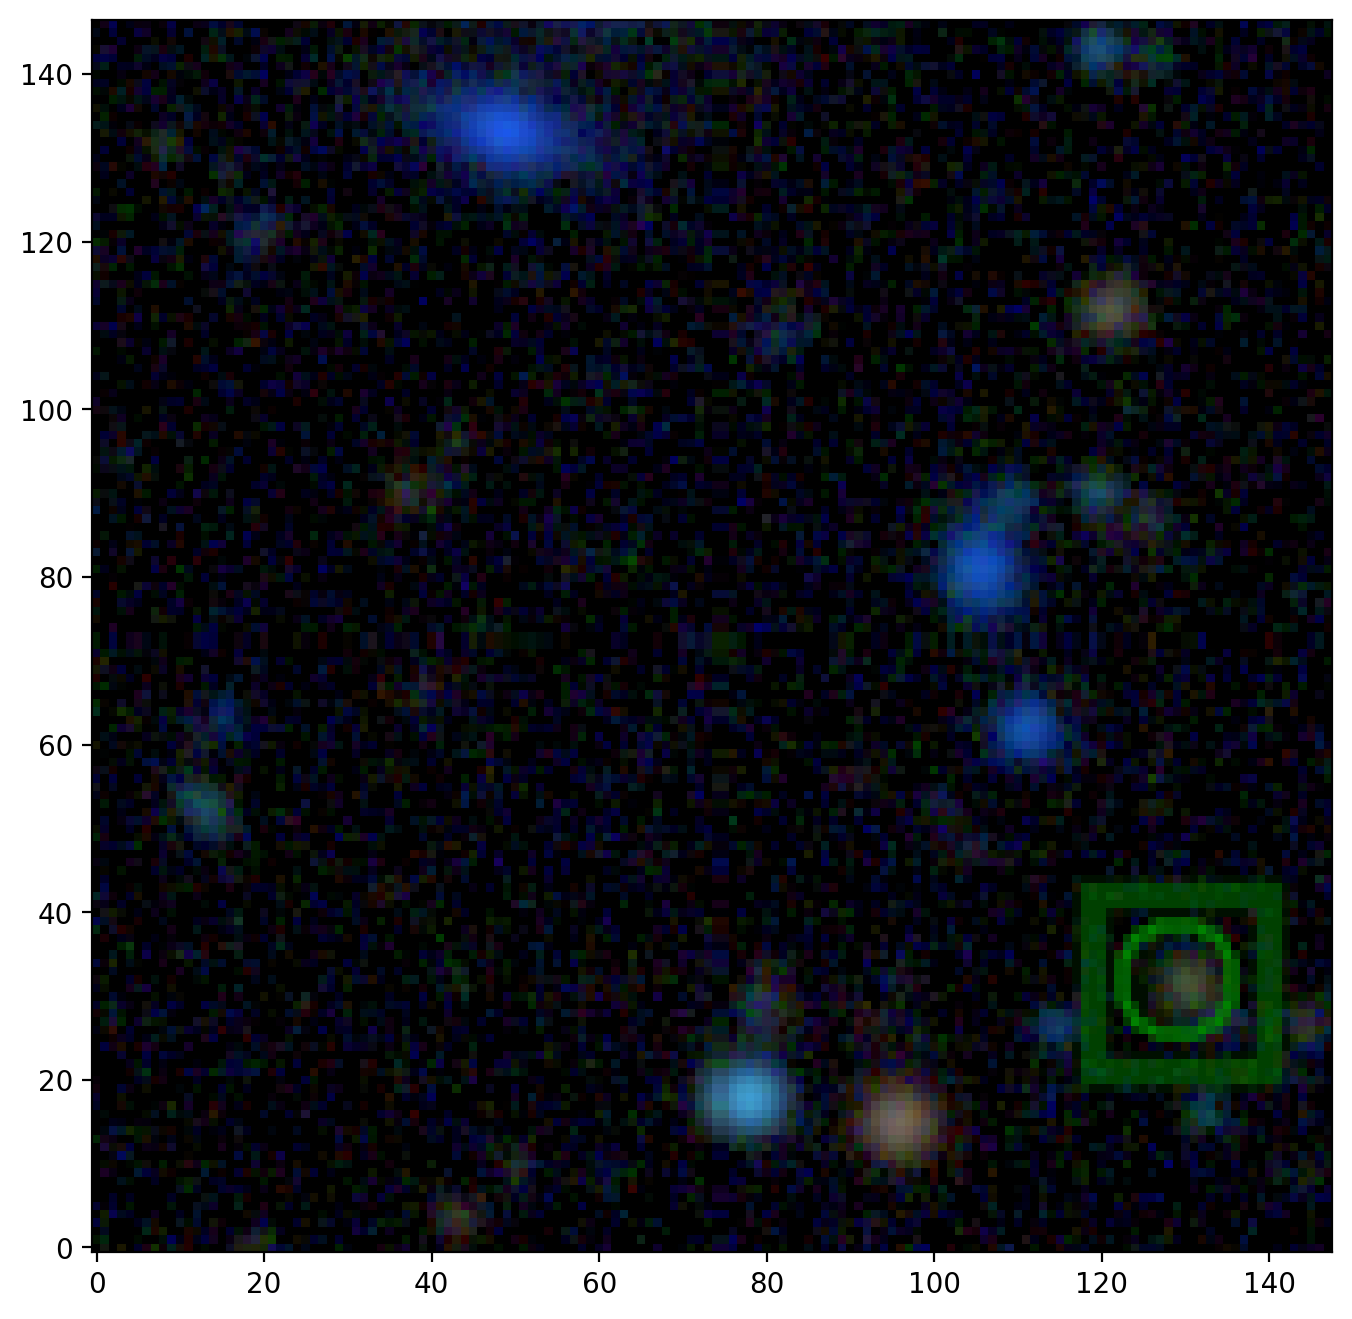

In [56]:
# coadd_img = data['lsst_img'] # ugrizy
coadd_img = np.load(ddict['file_name']) # ugrizy
g = coadd_img[1, :, :]
r = coadd_img[2, :, :]
i = coadd_img[3, :, :]

stretch=0.5
Q = 10
lsst_img_rgb = make_lupton_rgb(g, r, i, minimum=0, stretch=stretch, Q=Q)
# lsst_img_rgb = coadd_img[3, :, :]
# lsst_img_rgb = make_rgb_image(g, r, i)
print(lsst_img_rgb.shape)
print("total instances:", len(ddict["annotations"]))


v0 = Visualizer(
    lsst_img_rgb,
    metadata=astrotest_metadata,
    scale=1,
    enable_color_jitter=False,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=True)
# ax1 = plt.subplot(1, 1, 1)
plt.figure(figsize=(8, 8))
plt.imshow(groundTruth.get_image(), 
           origin='lower',
           aspect='auto',
          )

Great! We've successfully created a ground-truth annotation for a single object within a single cutout from one tile in the format DeepDISC requires using the object's morphological information. Now, we need to scale this process to all the objects in the cutout, all the cutouts in a tile and finally all the tiles we have.

#### For All Objects in Cutout

In [57]:
def process_object(obj_entry, survey, se_kernel, obj_idx, cutout_id, noise, snr_lvl=5):
    """
    Processes a single object from the truth catalog to generate an annotation or a rejection log.
    """
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    segs = []

    # simulate the object and create segmentation masks for each band
    for i, filt in enumerate(filters):
        try:
            # isolated image of object
            conv_obj, psf = convolve_source(obj_entry, survey, filt, noise[i])
            #convolve by the psf and threshold with noise multiplied by psf area (Bosch 2018)
            conv2_obj = galsim.Convolve(conv_obj, psf)
            image = galsim.Image(128, 128, scale=survey.pixel_scale.to_value("arcsec"))
            im = conv2_obj.drawImage(image, scale=survey.pixel_scale.to_value("arcsec"), method='no_pixel')
            # estimate of PSF area
            psf_img = psf.drawImage(nx=64, ny=64)
            psf_fac = np.sum(psf_img.array**2)
            imd = np.expand_dims(np.expand_dims(im.array, 0), 0)
            var = noise[i]**2
            # segmentation mask using the fixed SNR threshold
            maskf = btk.metrics.utils.get_segmentation(imd, var * psf_fac, sigma_noise=snr_lvl)[0][0]
            # dilate the mask by the psf size
            maskf = cv2.morphologyEx(maskf, cv2.MORPH_DILATE, se_kernel)   
            segs.append(maskf)
        
        except SourceNotVisible:
            # runs if the source's flux was zero for this filter
            print(f"Cutout ({cutout_id}): Object {obj_idx} not visible in filter {filt}. Flux is zero! Skipping.")
            pass
            
        except Exception as e:
            # galsim fails, for example, when the star has a really high flux meaning the FFT size will be massive
            print(f"Cutout ({cutout_id}): Galsim failed for {obj_idx} in {filt}! Below is the error:\n {e}")
            pass
            # For now, we create an empty mask to trigger rejection.
            # segs.append(np.zeros((128, 128), dtype=bool)) 
    
    if segs:
        # add masks in separate bands
        combined_mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)
    else:
        print(f"\nNo filters were able to produce a segmentation mask (due to Galsim errors)")
        combined_mask = None # will only happens if galsim fails in all filters
        
    obj_id = int(obj_entry['id']) if obj_entry['truth_type'] == 2 else int(obj_entry['cosmodc2_id'])
    base_rejected_obj = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true'],
        'mask': combined_mask, # store mask even if rejected
    }
    for filt in filters:
        base_rejected_obj[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        base_rejected_obj[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
    
    if np.sum(combined_mask) == 0:
        base_rejected_obj['reason'] = 'empty_mask'
        return 'rejected', base_rejected_obj

    if np.sum(combined_mask) < 12:
        base_rejected_obj['reason'] = 'small_mask_12px'
        return 'rejected', base_rejected_obj

    bbox_coords = get_bbox(combined_mask)
    if bbox_coords is None:
        base_rejected_obj['reason'] = 'invalid_bbox' # Should be caught by empty mask, but just in case
        return 'rejected', base_rejected_obj
    
    y0, y1, x0, x1 = bbox_coords
    w, h = x1 - x0, y1 - y0
    
    # bbox relative to full cutout coordinates
    cutout_x, cutout_y = int(obj_entry['cutout_x']), int(obj_entry['cutout_y'])
    bbox = [cutout_x - w/2, cutout_y - h/2, w, h]

    # contours for segmentation
    contours, _ = cv2.findContours((combined_mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten()
        if len(contour) > 4: # Must have at least 3 points
            # Adjust contour coordinates to be relative to the full cutout
            contour[::2] += int(np.rint(cutout_x)) - (x0 + w//2)
            contour[1::2] += int(np.rint(cutout_y)) - (y0 + h//2)
            segmentation.append(contour.tolist())

    if len(segmentation) == 0:
        base_rejected_obj['reason'] = 'invalid_contours'
        return 'rejected', base_rejected_obj

    # successful ann
    obj_md = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,     
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'bbox': bbox,
        'bbox_mode': 1, # BoxMode.XYWH_ABS
        'area': w * h,
        'segmentation': segmentation,
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true']  
    }
    for filt in filters:
        obj_md[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        obj_md[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        
    return 'success', obj_md

def process_cutout(cutout_data, snr_lvl=5):
    """
    Generates annotation dictionaries for all objs in a given cutout.
    """
    if cutout_data['is_empty']:
        print(f"Skipping empty cutout {cutout_data['cutout_id']}")
        return None, None

    truth_cat = cutout_data['truth_cat']
    if truth_cat.empty:
        print(f"Skipping cutout {cutout_data['cutout_id']} with empty truth catalog.")
        return None, None
    
    dcut = dcut_reformat(truth_cat)
    survey = btk.survey.get_surveys("LSST")
    
    # structuring element for mask dilation
    # The psf variations are small between bands, so just using i-band is ok
    fwhm = survey.get_filter('i').psf.calculateFWHM()
    sig = gaussian_fwhm_to_sigma * fwhm / survey.pixel_scale.to_value("arcsec") # shld be / 0.2
    se_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2 * sig), int(2 * sig)))

    annotations = []
    rejected_objs = []
    noise = np.array([sigma_clipped_stats(img)[-1] for img in cutout_data['lsst_img']])


    print(f"Processing {len(dcut)} objects for cutout {cutout_data['cutout_id']}...")
    for idx, obj in dcut.iterrows():
        status, result_dict = process_object(obj, survey, se_kernel, idx, 
                                             cutout_data['cutout_id'], 
                                             noise,
                                             snr_lvl)
        if status == 'success':
            annotations.append(result_dict)
        else:
            rejected_objs.append(result_dict)
    
    print(f"Finished processing. Found {len(annotations)} successful annotations and {len(rejected_objs)} rejections.")

    wcs_df = pd.read_json(f"{cutout_loader.lsst_dir}/dc2_{cutout_data['tile']}/wcs_{cutout_data['tile']}.json")
    wcs = wcs_df.loc[wcs_df['cutout_id'] == cutout_data['cutout_id'], 'wcs_header'].iloc[0]
    success_dict = None
    if annotations:
        base_filename = f"c{cutout_data['cutout_id']}_{cutout_data['tile']}"
        success_dict = {
            "file_name": cutout_data['paths']['lsst_img'],
            "image_id": cutout_data['cutout_id'],
            "height": cutout_data['lsst_img'].shape[1],
            "width": cutout_data['lsst_img'].shape[2],
            "tile": cutout_data['tile'],
            "det_cat_path": cutout_data['paths']['det_cat'],
            "truth_cat_path": cutout_data['paths']['truth_cat'],
            "matched_det_path": cutout_data['paths']['det_cat'].replace('det_', 'matched_'),
            "wcs": wcs,
            "annotations": annotations
        }

    rejected_dict = None
    if rejected_objs:
        base_filename = f"c{cutout_data['cutout_id']}_{cutout_data['tile']}"
        rejected_dict = {
            "file_name": cutout_data['paths']['lsst_img'],
            "image_id": cutout_data['cutout_id'],
            "height": cutout_data['lsst_img'].shape[1],
            "width": cutout_data['lsst_img'].shape[2],
            "tile": cutout_data['tile'],
            "det_cat_path": cutout_data['paths']['det_cat'],
            "truth_cat_path": cutout_data['paths']['truth_cat'],
            "matched_det_path": cutout_data['paths']['det_cat'].replace('det_', 'matched_'),
            "wcs": wcs,
            "rejected_objs": rejected_objs
        }

    return success_dict, rejected_dict

##### SNR LVL 5

In [58]:
tile_md = []
tile_rejected_md = []

cutout_loader = LSSTCutout(
    root_dir=root_dir,
    lsst_dir=lsst_dir,
    lsst_ups_dir=lsst_ups_dir,
    roman_dir=roman_dir,
    all_tiles=all_tiles,
    cutouts_per_tile=225
)
data = cutout_loader.get_random_cutout(tile='53.25_-41.8', cutout_id=133)

if data:
    # process the entire cutout
    success_ddict, rejected_ddict = process_cutout(data, snr_lvl=5)

    # append the final dicts to the tile-level lists
    if success_ddict:
        tile_md.append(success_ddict)
    if rejected_ddict:
        tile_rejected_md.append(rejected_ddict)

    print("\n--- Results ---")
    print(f"Total successful annotation sets in tile_md: {len(tile_md)}")
    print(f"Total rejected object sets in tile_rejected_md: {len(tile_rejected_md)}")
    if tile_md:
        print("\nExample Success Dictionary:")
        print({k: v for k, v in tile_md[0].items() if k != 'annotations'})
        print(f"  - Number of annotations: {len(tile_md[0]['annotations'])}")

    if tile_rejected_md:
        print("\nExample Rejection Dictionary:")
        print({k: v for k, v in tile_rejected_md[0].items() if k != 'rejected_objs'})
        print(f"  - Number of rejected objects: {len(tile_rejected_md[0]['rejected_objs'])}")

Processing 156 objects for cutout 133...
Finished processing. Found 30 successful annotations and 126 rejections.

--- Results ---
Total successful annotation sets in tile_md: 1
Total rejected object sets in tile_rejected_md: 1

Example Success Dictionary:
{'file_name': './lsst_data/truth/dc2_53.25_-41.8/full_c133_53.25_-41.8.npy', 'image_id': 133, 'height': 147, 'width': 148, 'tile': '53.25_-41.8', 'det_cat_path': './lsst_data/truth/dc2_53.25_-41.8/det_c133_53.25_-41.8.json', 'truth_cat_path': './lsst_data/truth/dc2_53.25_-41.8/truth_c133_53.25_-41.8.json', 'matched_det_path': './lsst_data/truth/dc2_53.25_-41.8/matched_c133_53.25_-41.8.json', 'wcs': "WCSAXES =                    2                                                  CRPIX1  =  -6934.0000000000000                                                  CRPIX2  =  -10449.000000000000                                                  CRVAL1  =   53.701657458563545                                                  CRVAL2  =  -42.39669

(147, 148, 3)
total instances: 30


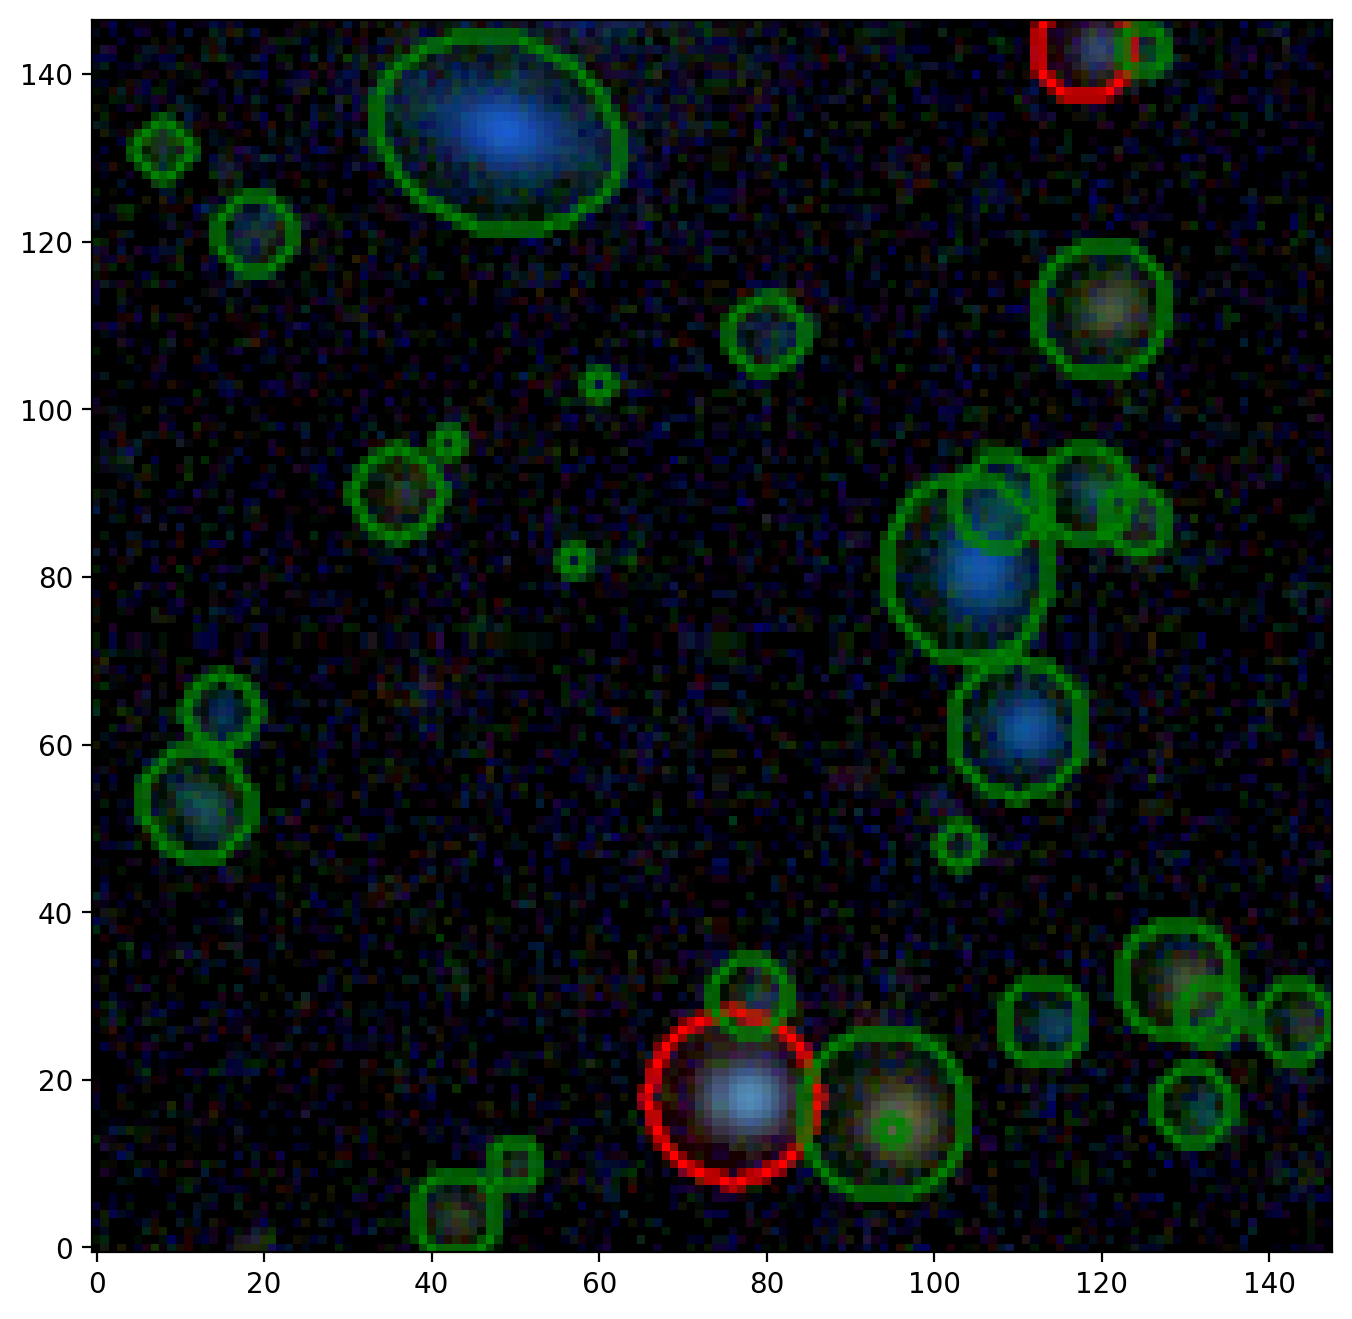

In [59]:
ddict = tile_md[0]
coadd_img = np.load(ddict['file_name']) # ugrizy
g = coadd_img[1, :, :]
r = coadd_img[2, :, :]
i = coadd_img[3, :, :]

stretch=0.5
Q = 10
lsst_img_rgb = make_lupton_rgb(g, r, i, minimum=0, stretch=stretch, Q=Q)
# lsst_img_rgb = coadd_img[3, :, :]
# lsst_img_rgb = make_rgb_image(g, r, i)
print(lsst_img_rgb.shape)
print("total instances:", len(ddict["annotations"]))


v0 = Visualizer(
    lsst_img_rgb,
    metadata=astrotest_metadata,
    scale=1,
    enable_color_jitter=False,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=False)
# ax1 = plt.subplot(1, 1, 1)
plt.figure(figsize=(8, 8))
plt.imshow(groundTruth.get_image(), 
           origin='lower',
           aspect='auto',
          )

When SNR LVL = 5, we have 30 objects that pass our threshold and 126 objects that get rejected out of 156 objects. ~20% of objects pass our threshold.

From [Rubin Key Numbers](https://rubinobservatory.org/for-scientists/rubin-101/key-numbers), the nominal 5-sigma point source depth for the LSST i-band after 10 years is 26.8 magnitude. To account for the 5-year observation period of our coadds, we calculated this limit to a brighter magnitude of 26.42. Let's see how many objects will be present when we impose this magnitude cut (`mag_i < 26.42`) on the truth catalog. 

In [72]:
print(len(data['truth_cat'][data['truth_cat']['mag_i'] < 26.42]), 'objects')

32 objects


Thus, when we processed the cutout using a corresponding 5-sigma detection threshold (snr_lvl=5), the pipeline successfully generated valid annotations for 30/32 objects. This corresponds to a completeness of 93.75% for our target population. This high level of completeness indicates that our simulation and segmentation process is robust and accurately captures the vast majority of objects within the expected sensitivity limits of the 5-year survey data. The two missed objects represent marginal cases at the faintness limit, which is expected when dealing with detection thresholds.

##### SNR LVL 2

In [71]:
tile_md = []
tile_rejected_md = []

cutout_loader = LSSTCutout(
    root_dir=root_dir,
    lsst_dir=lsst_dir,
    lsst_ups_dir=lsst_ups_dir,
    roman_dir=roman_dir,
    all_tiles=all_tiles,
    cutouts_per_tile=225
)
data = cutout_loader.get_random_cutout(tile='53.25_-41.8', cutout_id=133)

if data:
    # process the entire cutout
    success_ddict, rejected_ddict = process_cutout(data, snr_lvl=2)

    # append the final dicts to the tile-level lists
    if success_ddict:
        tile_md.append(success_ddict)
    if rejected_ddict:
        tile_rejected_md.append(rejected_ddict)

    print("\n--- Results ---")
    print(f"Total successful annotation sets in tile_md: {len(tile_md)}")
    print(f"Total rejected object sets in tile_rejected_md: {len(tile_rejected_md)}")
    if tile_md:
        print("\nExample Success Dictionary:")
        print({k: v for k, v in tile_md[0].items() if k != 'annotations'})
        print(f"  - Number of annotations: {len(tile_md[0]['annotations'])}")

    if tile_rejected_md:
        print("\nExample Rejection Dictionary:")
        print({k: v for k, v in tile_rejected_md[0].items() if k != 'rejected_objs'})
        print(f"  - Number of rejected objects: {len(tile_rejected_md[0]['rejected_objs'])}")

Processing 156 objects for cutout 133...
Finished processing. Found 77 successful annotations and 79 rejections.

--- Results ---
Total successful annotation sets in tile_md: 1
Total rejected object sets in tile_rejected_md: 1

Example Success Dictionary:
{'file_name': './lsst_data/truth/dc2_53.25_-41.8/full_c133_53.25_-41.8.npy', 'image_id': 133, 'height': 147, 'width': 148, 'tile': '53.25_-41.8', 'det_cat_path': './lsst_data/truth/dc2_53.25_-41.8/det_c133_53.25_-41.8.json', 'truth_cat_path': './lsst_data/truth/dc2_53.25_-41.8/truth_c133_53.25_-41.8.json', 'matched_det_path': './lsst_data/truth/dc2_53.25_-41.8/matched_c133_53.25_-41.8.json', 'wcs': "WCSAXES =                    2                                                  CRPIX1  =  -6934.0000000000000                                                  CRPIX2  =  -10449.000000000000                                                  CRVAL1  =   53.701657458563545                                                  CRVAL2  =  -42.396694

(147, 148, 3)
total instances: 77


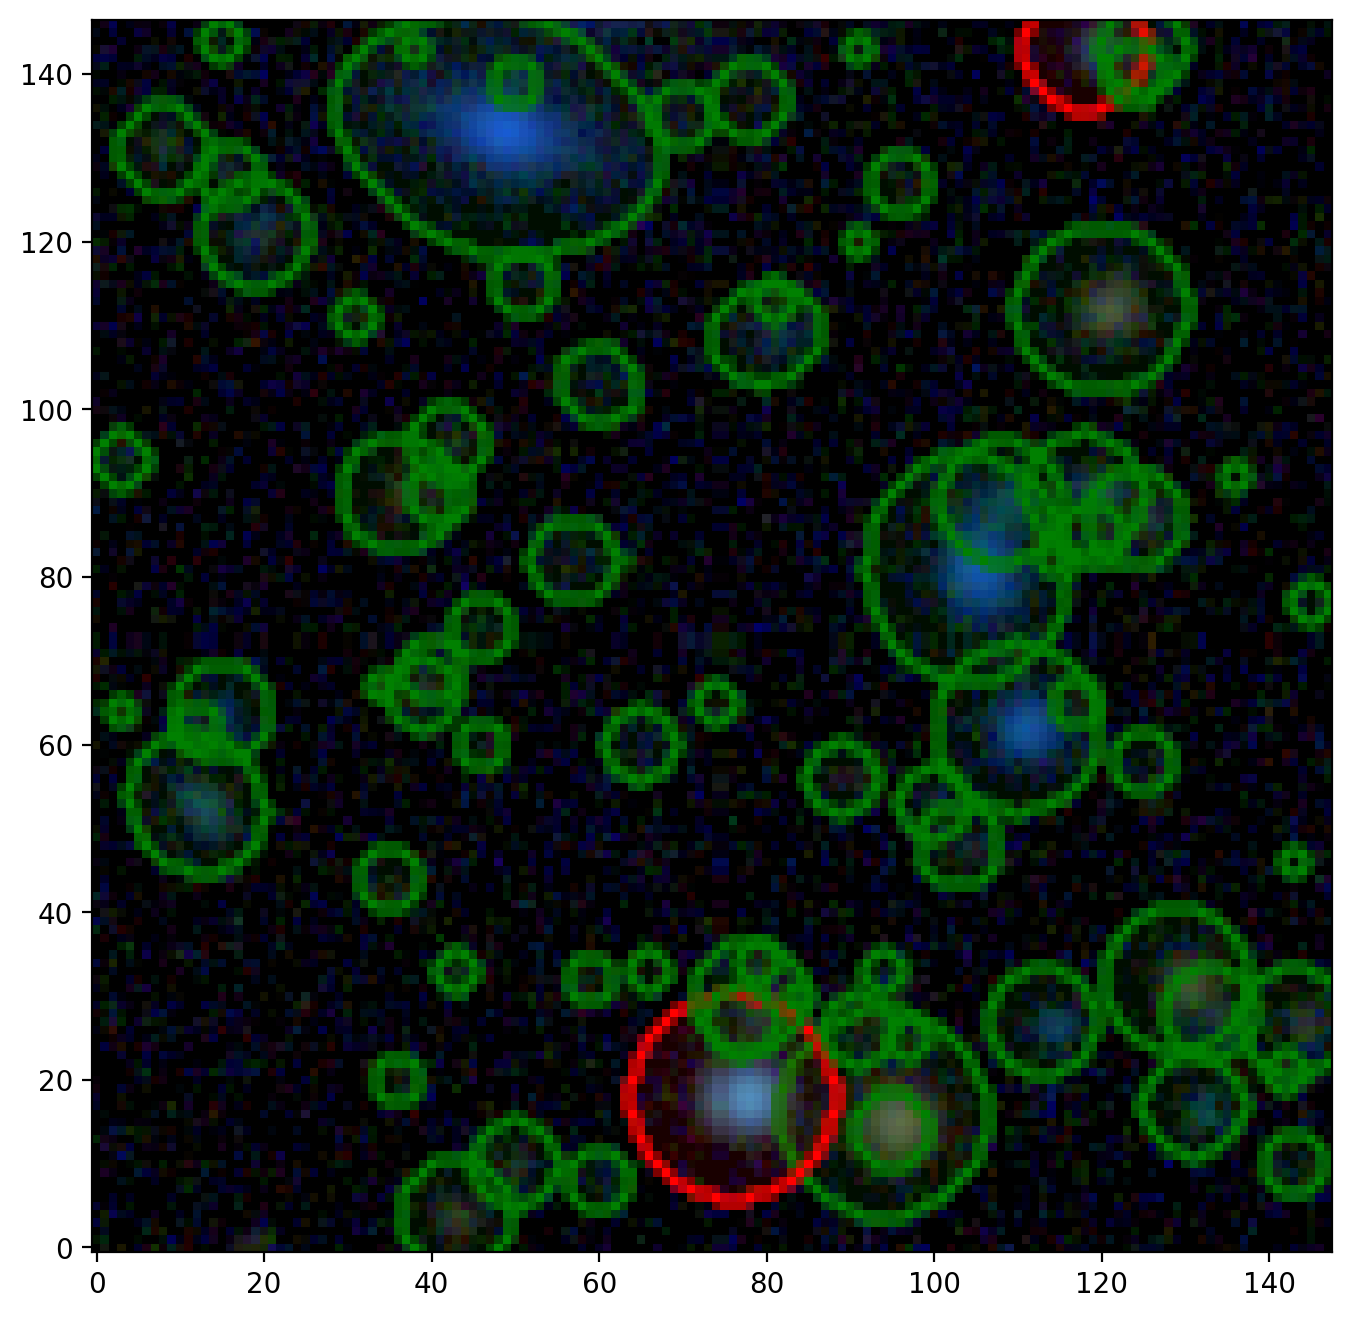

In [73]:
ddict = tile_md[0]
coadd_img = np.load(ddict['file_name']) # ugrizy
g = coadd_img[1, :, :]
r = coadd_img[2, :, :]
i = coadd_img[3, :, :]

stretch=0.5
Q = 10
lsst_img_rgb = make_lupton_rgb(g, r, i, minimum=0, stretch=stretch, Q=Q)
# lsst_img_rgb = coadd_img[3, :, :]
# lsst_img_rgb = make_rgb_image(g, r, i)
print(lsst_img_rgb.shape)
print("total instances:", len(ddict["annotations"]))


v0 = Visualizer(
    lsst_img_rgb,
    metadata=astrotest_metadata,
    scale=1,
    enable_color_jitter=False,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=False)
# ax1 = plt.subplot(1, 1, 1)
plt.figure(figsize=(8, 8))
plt.imshow(groundTruth.get_image(), 
           origin='lower',
           aspect='auto',
          )

When SNR LVL = 2, we have 77 objects that pass our threshold and 79 objects that get rejected out of 156 objects. Now, ~49% of objects pass our threshold. This makes sense as a lower threshold means annotations are being generated for a larger population of fainter, lower-surface-brightness objects that were previously being rejected.

Great! We have successfully been able to do the following 
- Generated proper segmentation masks and COCO-format annotations with bounding boxes and polygon segmentations for all objects within a single cutout in a single tile
-  Experimented with different SNR thresholds

Now, we need to continue scaling! We need to do the following
- [ ] All cutouts in a tile (instead of just cutout 133)
- [ ] All tiles (instead of just tile 53.25_-41.8)

## All Cutouts in Single Tile

The current `LSSTCutout` class is useful but has unnecessary functionality for this section. So, let's extract all the relevant methods and global variables and modify them to suit our needs. 

In [78]:
root_dir = './lsst_data/'
lsst_dir = f'{root_dir}truth/'
all_tiles = [
    "50.93_-38.8", "50.93_-42.0", "51.34_-41.3", "51.37_-38.3",
    "51.53_-40.0", "52.31_-41.6", "52.40_-41.1", "52.49_-39.1",
    "52.93_-40.8", "53.25_-41.8", "53.75_-38.9", "54.24_-38.3",
    "54.31_-41.6", "55.03_-41.9", "55.54_-41.9", "56.06_-39.8"
]
# we shld prob just dynamically calculate this by looking through the truth folders
cutouts_per_tile = 225

def load_cutout_data(tile, wcs_df, cutout_id):
    """Load essential truth catalog data for a specific cutout"""
    base_filename = f'c{cutout_id}_{tile}'
    paths = {
        'lsst_img': f'{lsst_dir}dc2_{tile}/full_{base_filename}.npy',
        'truth_cat': f'{lsst_dir}dc2_{tile}/truth_{base_filename}.json',
        'det_cat': f'{lsst_dir}dc2_{tile}/det_{base_filename}.json',
        'matched_det': f'{lsst_dir}dc2_{tile}/matched_{base_filename}.json'
    }

    if not os.path.exists(paths['lsst_img']):
        # we can handle this in the main loop by creating empty dictionaries
        print(f"Warning: Image file for cutout {cutout_id} from tile {tile} does not exist! Skipping.")
        return None

    try:
        lsst_img = np.load(paths['lsst_img'])
        height, width = lsst_img.shape[1], lsst_img.shape[2]
        #estimate sig-clipped background noise
        noise = np.array([sigma_clipped_stats(img)[-1] for img in lsst_img])
        del lsst_img
        # wcs of cutout and account for cases where wcs doesn't exist
        wcs = wcs_df.loc[wcs_df['cutout_id'] == cutout_id, 'wcs_header'].iloc[0] if any(wcs_df['cutout_id'] == cutout_id) else None
        # load truth cat if it exists, otherwise create empty dfs
        truth_cat = pd.read_json(paths['truth_cat'], orient='records') if os.path.exists(paths['truth_cat']) else pd.DataFrame()
        return {
            'tile': tile,
            'cutout_id': cutout_id,
            'truth_cat': truth_cat,
            'width': width,
            'height': height,
            'wcs': wcs,
            'paths': paths,
            'noise': noise
        }
    except Exception as e:
        print(f"Error loading cutout {cutout_id} from tile {tile}: {e}")
        return None

In [80]:
def process_object(obj_entry, survey, se_kernel, obj_idx, cutout_id, noise, snr_lvl=5):
    """
    Processes a single object from the truth catalog to generate an annotation or a rejection log.
    """
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    segs = []
            
    # simulate the object and create segmentation masks for each band
    for i, filt in enumerate(filters):
        try:
            # isolated image of object
            conv_obj, psf = convolve_source(obj_entry, survey, filt, noise[i])
            #convolve by the psf and threshold with noise multiplied by psf area (Bosch 2018)
            conv2_obj = galsim.Convolve(conv_obj, psf)
            image = galsim.Image(128, 128, scale=survey.pixel_scale.to_value("arcsec"))
            im = conv2_obj.drawImage(image, scale=survey.pixel_scale.to_value("arcsec"), method='no_pixel')
            # estimate of PSF area
            psf_img = psf.drawImage(nx=64, ny=64)
            psf_fac = np.sum(psf_img.array**2)
            imd = np.expand_dims(np.expand_dims(im.array, 0), 0)
            var = noise[i]**2
            # segmentation mask using the fixed SNR threshold
            maskf = btk.metrics.utils.get_segmentation(imd, var * psf_fac, sigma_noise=snr_lvl)[0][0]
            # dilate the mask by the psf size
            maskf = cv2.morphologyEx(maskf, cv2.MORPH_DILATE, se_kernel)   
            segs.append(maskf)
        
        except SourceNotVisible:
            # runs if the source's flux was zero for this filter
            print(f"Cutout ({cutout_id}): Object {obj_idx} not visible in filter {filt}. Flux is zero! Skipping.")
            pass
        
        except Exception as e:
            # galsim fails, for example, when the star has a really high flux meaning the FFT size will be massive
            print(f"Cutout ({cutout_id}): Galsim failed for {obj_idx} in {filt}! Below is the error:\n {e}")
            pass
            # For now, we create an empty mask to trigger rejection.
            # segs.append(np.zeros((128, 128), dtype=bool)) 
    
    if segs:
        # add masks in separate bands
        combined_mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)
    else:
        combined_mask = None # will only happens if galsim fails in all filters

    obj_id = int(obj_entry['id']) if obj_entry['truth_type'] == 2 else int(obj_entry['cosmodc2_id'])
    base_rejected_obj = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true'],
        'mask': combined_mask, # store mask even if rejected
    }
    for filt in filters:
        base_rejected_obj[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        base_rejected_obj[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
    
    if np.sum(combined_mask) == 0:
        base_rejected_obj['reason'] = 'empty_mask'
        return 'rejected', base_rejected_obj

    if np.sum(combined_mask) < 12:
        base_rejected_obj['reason'] = 'small_mask_12px'
        return 'rejected', base_rejected_obj

    bbox_coords = get_bbox(combined_mask)
    if bbox_coords is None:
        base_rejected_obj['reason'] = 'invalid_bbox' # Should be caught by empty mask, but just in case
        return 'rejected', base_rejected_obj
    
    y0, y1, x0, x1 = bbox_coords
    w, h = x1 - x0, y1 - y0
    
    # bbox relative to full cutout coordinates
    cutout_x, cutout_y = int(obj_entry['cutout_x']), int(obj_entry['cutout_y'])
    bbox = [cutout_x - w/2, cutout_y - h/2, w, h]

    # contours for segmentation
    contours, _ = cv2.findContours((combined_mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten()
        if len(contour) > 4: # Must have at least 3 points
            # Adjust contour coordinates to be relative to the full cutout
            contour[::2] += int(np.rint(cutout_x)) - (x0 + w//2)
            contour[1::2] += int(np.rint(cutout_y)) - (y0 + h//2)
            segmentation.append(contour.tolist())

    if len(segmentation) == 0:
        base_rejected_obj['reason'] = 'invalid_contours'
        return 'rejected', base_rejected_obj

    # successful ann
    obj_md = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,     
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'bbox': bbox,
        'bbox_mode': 1, # BoxMode.XYWH_ABS
        'area': w * h,
        'segmentation': segmentation,
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true']  
    }
    for filt in filters:
        obj_md[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        obj_md[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        
    return 'success', obj_md

def process_cutout(cutout_data, snr_lvl=5):
    """Generates annotation dicts for all objects in a given cutout."""
    # cutout file does not exist but we still need an empty entry
    if cutout_data is None:
        return {}, {}

    truth_cat = cutout_data['truth_cat']
    
    base_dict = {
        "file_name": cutout_data['paths']['lsst_img'],
        "image_id": cutout_data['cutout_id'],
        "height": cutout_data['height'],
        "width": cutout_data['width'],
        "tile": cutout_data['tile'],
        "det_cat_path": cutout_data['paths']['det_cat'],
        "truth_cat_path": cutout_data['paths']['truth_cat'],
        "matched_det_path": cutout_data['paths']['matched_det'],
        "wcs": cutout_data['wcs']
    }

    if truth_cat.empty:
        # empty dicts 
        print(f"Skipping cutout {cutout_data['cutout_id']} with empty truth catalog.")
        success_dict = {**base_dict, "annotations": []}
        rejected_dict = {**base_dict, "rejected_objs": []}
        return success_dict, rejected_dict

    survey = btk.survey.get_surveys("LSST")
    # structuring element for mask dilation
    # The psf variations are small between bands, so just using i-band is ok
    fwhm = survey.get_filter('i').psf.calculateFWHM()
    sig = gaussian_fwhm_to_sigma * fwhm / survey.pixel_scale.to_value("arcsec")
    se_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2 * sig), int(2 * sig)))

    dcut = dcut_reformat(truth_cat)
    
    annotations = []
    rejected_objs = []
    for idx, obj in dcut.iterrows():        
        status, result_dict = process_object(obj, survey, se_kernel, idx, cutout_data['cutout_id'], cutout_data['noise'], snr_lvl)
        if status == 'success':
            annotations.append(result_dict)
        else:
            rejected_objs.append(result_dict)
    
    success_dict = {**base_dict, "annotations": annotations}
    rejected_dict = {**base_dict, "rejected_objs": rejected_objs}
    
    return success_dict, rejected_dict

def process_and_save_tile(tile_name, snr_lvl=5):
    """
    Processes all cutouts for a given tile and saves the results to JSON files.
    """
    print(f"--- Starting processing for tile: {tile_name} ---")
    tile_md = []
    tile_rejected_md = []
    # grab wcs
    wcs_df = pd.read_json(f"{lsst_dir}dc2_{tile}/wcs_{tile}.json")

    for cutout_id in range(cutouts_per_tile):
        print(f"Processing {tile_name} | Cutout {cutout_id}/{cutouts_per_tile - 1}...")
        cutout_data = load_cutout_data(tile_name, wcs_df, cutout_id)
        
        success_ddict, rejected_ddict = process_cutout(cutout_data, snr_lvl)
        
        if success_ddict:
            tile_md.append(success_ddict)
        if rejected_ddict:
            tile_rejected_md.append(rejected_ddict)

    print(f"\n--- Finished processing for tile: {tile_name} ---")

    # save anns and rejected objs
    output_dir_ann = f"./lsst_data/annotations_lvl{snr_lvl}/"
    output_dir_rej = f"./lsst_data/rejected_objs_lvl{snr_lvl}/"
    os.makedirs(output_dir_ann, exist_ok=True)
    os.makedirs(output_dir_rej, exist_ok=True)
    
    ann_path = os.path.join(output_dir_ann, f"dc2_{tile_name}.json")
    rej_path = os.path.join(output_dir_rej, f"dc2_{tile_name}.json")

    if tile_md:
        print(f"Saving {len(tile_md)} annotation sets to {ann_path}")
#         converted_tile_md = convert_for_json(tile_md)
        pd.DataFrame(tile_md).to_json(ann_path, orient='records', indent=4)
    else:
        print("No successful annotations to save.")
        
    if tile_rejected_md:
        print(f"Saving {len(tile_rejected_md)} rejected object sets to {rej_path}")
#         converted_rejected_md = convert_for_json(tile_rejected_md)
        pd.DataFrame(tile_rejected_md).to_json(rej_path, orient='records', indent=4)
    else:
        print("No rejected objects to save.")

In [81]:
cutouts_per_tile = 1
if __name__ == "__main__":
    start_time = time.time()
    # tile to be processed
    tile = "53.25_-41.8"
    process_and_save_tile(tile, snr_lvl=5)
    end_time = time.time()
    print(f"\nPipeline finished. Took {end_time - start_time} seconds for {cutouts_per_tile} cutouts in TILE: {tile}.")

--- Starting processing for tile: 53.25_-41.8 ---
Processing 53.25_-41.8 | Cutout 0/0...

--- Finished processing for tile: 53.25_-41.8 ---
Saving 1 annotation sets to ./lsst_data/annotations_lvl5/dc2_53.25_-41.8.json
Saving 1 rejected object sets to ./lsst_data/rejected_objs_lvl5/dc2_53.25_-41.8.json

Pipeline finished. Took 6.152376890182495 seconds for 1 cutouts in TILE: 53.25_-41.8.


In [83]:
cutouts_per_tile = 20
if __name__ == "__main__":
    start_time = time.time()
    # tile to be processed
    tile = "53.25_-41.8"
    process_and_save_tile(tile, snr_lvl=5)
    end_time = time.time()
    print(f"\nPipeline finished. Took {end_time - start_time} seconds for {cutouts_per_tile} cutouts in TILE: {tile}.")

--- Starting processing for tile: 53.25_-41.8 ---
Processing 53.25_-41.8 | Cutout 0/19...
Processing 53.25_-41.8 | Cutout 1/19...
Processing 53.25_-41.8 | Cutout 2/19...
Processing 53.25_-41.8 | Cutout 3/19...


KeyboardInterrupt: 

Ok, it seems to be working, but it takes ~8-10 seconds for each cutout to be fully processed meaning it would take ~37.5 minutes for a single tile that has 225 cutouts. This problem is an excellent case of what's known as "embarrassingly parallel," meaning each task (processing one cutout) is completely independent of the others. So, we can use multiprocessing to utilize all the CPU cores we have on our machine.

The strategy is to divide the 225 cutouts among a pool of worker processes. So, this current version of the notebook is being run with 32 CPU cores, meaning we can process 32 cutouts simultaneously, leading to a theoretical speedup of nearly 32x. This would reduce the runtime for one tile from ~37.5 minutes to about 1 minutes.

$$
\frac{2250 \text{ sec per cutout}}{32 \text{ CPU cores}} \approx 70 \text{ sec} \approx 1.2 \text{ minutes}
$$

Additionally, we note that previously, we were saving the entire 2D 128x128 mask array for rejected objects. However, this will become 16,384 integers in text form — which is very large and inefficient for scaling up. As such, we will instead save the mask in .npy format in a `rejected_masks/` folder and then just store the `mask_path` in the metadata for each object. This will still allow us to recover the mask if needed while reducing the data stored in the metadata.

### Using multiprocessing

In [84]:
root_dir = './lsst_data/'
lsst_dir = f'{root_dir}truth/'
rejected_mask_dir = f'{root_dir}rejected_objs_lvl5/rejected_masks/dc2_'
all_tiles = [
    "50.93_-38.8", "50.93_-42.0", "51.34_-41.3", "51.37_-38.3",
    "51.53_-40.0", "52.31_-41.6", "52.40_-41.1", "52.49_-39.1",
    "52.93_-40.8", "53.25_-41.8", "53.75_-38.9", "54.24_-38.3",
    "54.31_-41.6", "55.03_-41.9", "55.54_-41.9", "56.06_-39.8"
]
# we shld prob just dynamically calculate this by looking through the truth folders
cutouts_per_tile = 225

def load_cutout_data(tile, cutout_id, wcs_header=None):
    """Load essential truth catalog data for a specific cutout"""
    base_filename = f'c{cutout_id}_{tile}'
    paths = {
        'lsst_img': f'{lsst_dir}dc2_{tile}/full_{base_filename}.npy',
        'truth_cat': f'{lsst_dir}dc2_{tile}/truth_{base_filename}.json',
        'det_cat': f'{lsst_dir}dc2_{tile}/det_{base_filename}.json',
        'matched_det': f'{lsst_dir}dc2_{tile}/matched_{base_filename}.json'
    }

    if not os.path.exists(paths['lsst_img']):
        # we can handle this in the main loop by creating empty dictionaries
        print(f"Warning: Image file for cutout {cutout_id} from tile {tile} does not exist! Skipping.")
        return None

    try:
        lsst_img = np.load(paths['lsst_img'])
        height, width = lsst_img.shape[1], lsst_img.shape[2]
        #estimate sig-clipped background noise
        noise = np.array([sigma_clipped_stats(img)[-1] for img in lsst_img])
        del lsst_img
        # load truth cat if it exists, otherwise create empty dfs
        truth_cat = pd.read_json(paths['truth_cat'], orient='records') if os.path.exists(paths['truth_cat']) else pd.DataFrame()
        return {
            'tile': tile,
            'cutout_id': cutout_id,
            'truth_cat': truth_cat,
            'width': width,
            'height': height,
            'wcs': wcs_header,
            'paths': paths,
            'noise': noise
        }
    except Exception as e:
        print(f"Error loading cutout {cutout_id} from tile {tile}: {e}")
        return None

In [85]:
def process_object(obj_entry, survey, se_kernel, obj_idx, tile, cutout_id, noise, snr_lvl=5):
    """
    Processes a single object from the truth catalog to generate an annotation or a rejection log.
    """
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    segs = []
    # simulate the object and create segmentation masks for each band
    for i, filt in enumerate(filters):
        try:
            # isolated image of object
            conv_obj, psf = convolve_source(obj_entry, survey, filt, noise[i])
            #convolve by the psf and threshold with noise multiplied by psf area (Bosch 2018)
            conv2_obj = galsim.Convolve(conv_obj, psf)
            image = galsim.Image(128, 128, scale=survey.pixel_scale.to_value("arcsec"))
            im = conv2_obj.drawImage(image, scale=survey.pixel_scale.to_value("arcsec"), method='no_pixel')
            # estimate of PSF area
            psf_img = psf.drawImage(nx=64, ny=64)
            psf_fac = np.sum(psf_img.array**2)
            imd = np.expand_dims(np.expand_dims(im.array, 0), 0)
            var = noise[i]**2
            # segmentation mask using the fixed SNR threshold
            maskf = btk.metrics.utils.get_segmentation(imd, var * psf_fac, sigma_noise=snr_lvl)[0][0]
            # dilate the mask by the psf size
            maskf = cv2.morphologyEx(maskf, cv2.MORPH_DILATE, se_kernel)   
            segs.append(maskf)
        
        except SourceNotVisible:
            # runs if the source's flux was zero for this filter
            print(f"Cutout ({cutout_id}): Object {obj_idx} not visible in filter {filt}. Flux is zero! Skipping.")
            pass
        
        except Exception as e:
            # galsim fails, for example, when the star has a really high flux meaning the FFT size will be massive
            print(f"Cutout ({cutout_id}): Galsim failed for {obj_idx} in {filt}! Below is the error:\n {e}")
            pass
            # For now, we create an empty mask to trigger rejection.
            # segs.append(np.zeros((128, 128), dtype=bool))
    
    obj_id = int(obj_entry['id']) if obj_entry['truth_type'] == 2 else int(obj_entry['cosmodc2_id'])
    
    # now when an obj is rejected, save its mask and store the path
    def handle_rejection(reason, galsim_fail=False):
        if galsim_fail:
            mask_path = None
        else:
            mask_dir = os.path.join(rejected_mask_dir, tile, f"c{cutout_id}")
            os.makedirs(mask_dir, exist_ok=True)
            mask_path = os.path.join(mask_dir, f"mask_{obj_idx}.npy")
            np.save(mask_path, combined_mask)
        
        rejected_obj = {
            'obj_id': obj_id,
            'obj_truth_idx': obj_idx,
            'category_id': 1 if obj_entry['truth_type'] == 2 else 0,
            'ra': obj_entry['ra'],
            'dec': obj_entry['dec'],
            'redshift': obj_entry['redshift'],
            'size_true': obj_entry['size_true'],
            'ellipticity_1_true': obj_entry['ellipticity_1_true'],
            'ellipticity_2_true': obj_entry['ellipticity_2_true'],
            'reason': reason,
            'mask_path': mask_path
        }
        for filt in filters:
            rejected_obj[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
            rejected_obj[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        return 'rejected', rejected_obj
    
    if segs:
        # add masks in separate bands
        combined_mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)
    else:
        combined_mask = None # will only happens if galsim fails in all filters
        return handle_rejection('galsim_fail', galsim_fail=True)
    
    if np.sum(combined_mask) == 0:
        return handle_rejection('empty_mask')

    if np.sum(combined_mask) < 12:
        return handle_rejection('small_mask_12px')

    bbox_coords = get_bbox(combined_mask)
    if bbox_coords is None:
        return handle_rejection('invalid_bbox') # Should be caught by empty mask, but just in case
    
    y0, y1, x0, x1 = bbox_coords
    w, h = x1 - x0, y1 - y0
    
    # bbox relative to full cutout coordinates
    cutout_x, cutout_y = int(obj_entry['cutout_x']), int(obj_entry['cutout_y'])
    bbox = [cutout_x - w/2, cutout_y - h/2, w, h]

    # contours for segmentation
    contours, _ = cv2.findContours((combined_mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten()
        if len(contour) > 4: # Must have at least 3 points
            # Adjust contour coordinates to be relative to the full cutout
            contour[::2] += int(np.rint(cutout_x)) - (x0 + w//2)
            contour[1::2] += int(np.rint(cutout_y)) - (y0 + h//2)
            segmentation.append(contour.tolist())

    if len(segmentation) == 0:
        return handle_rejection('invalid_contours')

    # successful ann
    obj_md = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,     
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'bbox': bbox,
        'bbox_mode': 1, # BoxMode.XYWH_ABS
        'area': w * h,
        'segmentation': segmentation,
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true']  
    }
    for filt in filters:
        obj_md[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        obj_md[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        
    return 'success', obj_md

def process_cutout(cutout_data, snr_lvl=5):
    """Generates annotation dicts for all objects in a given cutout."""
    # cutout file does not exist but we still need an empty entry
    if cutout_data is None:
        return {}, {}

    truth_cat = cutout_data['truth_cat']
    
    base_dict = {
        "file_name": cutout_data['paths']['lsst_img'],
        "image_id": cutout_data['cutout_id'],
        "height": cutout_data['height'],
        "width": cutout_data['width'],
        "tile": cutout_data['tile'],
        "det_cat_path": cutout_data['paths']['det_cat'],
        "truth_cat_path": cutout_data['paths']['truth_cat'],
        "matched_det_path": cutout_data['paths']['matched_det'],
        "wcs": cutout_data['wcs']
    }

    if truth_cat.empty:
        # empty dicts 
        print(f"Skipping cutout {cutout_data['cutout_id']} with empty truth catalog.")
        success_dict = {**base_dict, "annotations": []}
        rejected_dict = {**base_dict, "rejected_objs": []}
        return success_dict, rejected_dict

    survey = btk.survey.get_surveys("LSST")
    # structuring element for mask dilation
    # The psf variations are small between bands, so just using i-band is ok
    fwhm = survey.get_filter('i').psf.calculateFWHM()
    sig = gaussian_fwhm_to_sigma * fwhm / survey.pixel_scale.to_value("arcsec")
    se_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2 * sig), int(2 * sig)))

    dcut = dcut_reformat(truth_cat)
    
    annotations = []
    rejected_objs = []
    for idx, obj in dcut.iterrows():
        status, result_dict = process_object(obj, survey, se_kernel, obj_idx=idx, 
                                             tile=cutout_data['tile'], 
                                             cutout_id=cutout_data['cutout_id'],
                                             noise=cutout_data['noise'],
                                             snr_lvl=snr_lvl)
        if status == 'success':
            annotations.append(result_dict)
        else:
            rejected_objs.append(result_dict)
    
    success_dict = {**base_dict, "annotations": annotations}
    rejected_dict = {**base_dict, "rejected_objs": rejected_objs}
    
    return success_dict, rejected_dict

In [86]:
import multiprocessing as mp
def process_single_cutout_wrapper(args):
    """
    A helper function to unpack args for use with multiprocessing.Pool
    It loads and processes a single cutout
    """
    tile_name, cutout_id, snr_lvl, wcs_header = args
    print(f"Processing {tile_name} | Cutout {cutout_id}...")
    
    cutout_data = load_cutout_data(tile_name, cutout_id, wcs_header)
    success_ddict, rejected_ddict = process_cutout(cutout_data, snr_lvl)
    return success_ddict, rejected_ddict

def process_and_save_tile(tile_name, snr_lvl=5):
    """
    Processes all cutouts for a given tile in parallel and saves the results.
    """
    print(f"--- Starting parallel processing for tile: {tile_name} ---")
    
    # lookup dict for wcs headers
    wcs_df = pd.read_json(f"{lsst_dir}dc2_{tile_name}/wcs_{tile_name}.json")
    wcs_lookup = wcs_df.set_index('cutout_id')['wcs_header'].to_dict()

    # args for each task
    tasks = [(tile_name, cutout_id, snr_lvl, wcs_lookup.get(cutout_id, None)) 
             for cutout_id in range(cutouts_per_tile)]
    
    num_processes = int(os.environ.get("SLURM_CPUS_ON_NODE", 16))
    print(f"Creating a pool of {num_processes} worker processes.")
    with mp.Pool(processes=num_processes) as pool:
        # pool.map distributes the tasks and blocks until all are complete
        results = pool.map(process_single_cutout_wrapper, tasks)
        pool.close()
        pool.join()

    tile_md = [res[0] for res in results if res[0]]
    tile_rejected_md = [res[1] for res in results if res[1]]

    print(f"\n--- Finished processing for tile: {tile_name} ---")
    print(f"Aggregated {len(tile_md)} successful annotation sets.")
    print(f"Aggregated {len(tile_rejected_md)} rejected object sets.")

    output_dir_ann = f"./lsst_data/annotations_lvl{snr_lvl}/"
    output_dir_rej = f"./lsst_data/rejected_objs_lvl{snr_lvl}/"
    os.makedirs(output_dir_ann, exist_ok=True)
    os.makedirs(output_dir_rej, exist_ok=True)

    ann_path = os.path.join(output_dir_ann, f"dc2_{tile_name}.json")
    rej_path = os.path.join(output_dir_rej, f"dc2_{tile_name}.json")

    if tile_md:
        print(f"Saving successful annotations to {ann_path}")
        pd.DataFrame(tile_md).to_json(ann_path, orient='records', indent=4)
    if tile_rejected_md:
        print(f"Saving rejected objects to {rej_path}")
        pd.DataFrame(tile_rejected_md).to_json(rej_path, orient='records', indent=4)

In [77]:
if __name__ == "__main__":
    start_time = time.time()
    tile = "53.25_-41.8"
    process_and_save_tile(tile, snr_lvl=5)
    end_time = time.time()
    print(f"\nPipeline finished. Took {end_time - start_time:.2f} seconds for {cutouts_per_tile} cutouts in TILE: {tile}.")

--- Starting parallel processing for tile: 53.25_-41.8 ---
Creating a pool of 64 worker processes.
Processing 53.25_-41.8 | Cutout 1...Processing 53.25_-41.8 | Cutout 0...Processing 53.25_-41.8 | Cutout 2...
Processing 53.25_-41.8 | Cutout 3...Processing 53.25_-41.8 | Cutout 5...Processing 53.25_-41.8 | Cutout 4...Processing 53.25_-41.8 | Cutout 8...Processing 53.25_-41.8 | Cutout 7...
Processing 53.25_-41.8 | Cutout 6...
Processing 53.25_-41.8 | Cutout 9...Processing 53.25_-41.8 | Cutout 15...Processing 53.25_-41.8 | Cutout 14...Processing 53.25_-41.8 | Cutout 19...


Processing 53.25_-41.8 | Cutout 16...Processing 53.25_-41.8 | Cutout 17...Processing 53.25_-41.8 | Cutout 18...

Processing 53.25_-41.8 | Cutout 20...Processing 53.25_-41.8 | Cutout 13...Processing 53.25_-41.8 | Cutout 22...Processing 53.25_-41.8 | Cutout 21...Processing 53.25_-41.8 | Cutout 23...
Processing 53.25_-41.8 | Cutout 25...Processing 53.25_-41.8 | Cutout 24...
Processing 53.25_-41.8 | Cutout 26...
Processing 5

In [ ]:
if __name__ == "__main__":
    start_time = time.time()
    tile = "55.03_-41.9"
    process_and_save_tile(tile, snr_lvl=5)
    end_time = time.time()
    print(f"\nPipeline finished. Took {end_time - start_time:.2f} seconds for {cutouts_per_tile} cutouts in TILE: {tile}.")

```
--- Starting parallel processing for tile: 55.03_-41.9 ---
Creating a pool of 64 worker processes.
Processing 55.03_-41.9 | Cutout 0...Processing 55.03_-41.9 | Cutout 1...Processing 55.03_-41.9 | Cutout 2...Processing 55.03_-41.9 | Cutout 3...Processing 55.03_-41.9 | Cutout 7...Processing 55.03_-41.9 | Cutout 4...Processing 55.03_-41.9 | Cutout 5...Processing 55.03_-41.9 | Cutout 6...Processing 55.03_-41.9 | Cutout 8...Processing 55.03_-41.9 | Cutout 9...Processing 55.03_-41.9 | Cutout 13...

...

Processing 55.03_-41.9 | Cutout 179...
Cutout (100): Object 151 not visible in filter u. Flux is zero! Skipping.
Processing 55.03_-41.9 | Cutout 197...
Cutout (197): Galsim failed for 0 in u! Below is the error:
 drawFFT requires an FFT that is too large.
The required FFT size would be 38884 x 38884, which requires 33.80 GB of memory.
If you can handle the large FFT, you may update gsparams.maximum_fft_size.
Cutout (197): Galsim failed for 0 in g! Below is the error:
 drawFFT requires an FFT that is too large.
The required FFT size would be 162766 x 162766, which requires 592.16 GB of memory.
If you can handle the large FFT, you may update gsparams.maximum_fft_size.
Cutout (197): Galsim failed for 0 in r! Below is the error:
 drawFFT requires an FFT that is too large.
The required FFT size would be 86408 x 86408, which requires 166.89 GB of memory.
If you can handle the large FFT, you may update gsparams.maximum_fft_size.
Cutout (197): Galsim failed for 0 in z! Below is the error:
 drawFFT requires an FFT that is too large.
The required FFT size would be 45448 x 45448, which requires 46.17 GB of memory.
If you can handle the large FFT, you may update gsparams.maximum_fft_size.
Cutout (197): Galsim failed for 0 in y! Below is the error:
 drawFFT requires an FFT that is too large.
The required FFT size would be 17268 x 17268, which requires 6.66 GB of memory.
If you can handle the large FFT, you may update gsparams.maximum_fft_size.

...

--- Finished processing for tile: 55.03_-41.9 ---
Aggregated 225 successful annotation sets.
Aggregated 225 rejected object sets.
Saving successful annotations to ./lsst_data/annotations_lvl5/dc2_55.03_-41.9.json
Saving rejected objects to ./lsst_data/rejected_objs_lvl5/dc2_55.03_-41.9.json

Pipeline finished. Took 74.65 seconds for 225 cutouts in TILE: 55.03_-41.9.
```

Great! Getting annotations for all the cutouts within a tile takes ~1-2 minutes now. This is much faster than before! Now, we need to do this for all 16 tiles we have.

For maximum efficiency, we can process all 16 tiles simultaneously by submitting 16 independent jobs to our computing cluster. Let's prepare a full script that we can copy into a Python file and submit to the cluster.

# Annotation Generation Script for Job Submission (All Tiles)

In [ ]:
# In case you need to point to pre-existing scarlet install
import sys
# change these paths to your specific directories where deepdisc and detectron2 are stored
sys.path.insert(0, '/home/yse2/deepdisc/src')
sys.path.insert(0, '/home/yse2/detectron2')

import os, json, glob
import time
import argparse
import multiprocessing as mp
import warnings
import numpy as np
import pandas as pd

import cv2
import deepdisc
import detectron2
print(deepdisc.__file__)
print(detectron2.__file__)
import scarlet
import sep
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

import galsim
import btk
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats


# --- Configuration ---
root_dir = './lsst_data/'
lsst_dir = f'{root_dir}truth/'

cutouts_per_tile = 225 # we shld prob just dynamically calculate this by looking through the truth folders
seed = 8312
rng = np.random.RandomState(seed)
grng = galsim.BaseDeviate(rng.randint(0, 2**30))

def e1e2_to_ephi(e1,e2):
    pa = np.arctan(e2/e1)
    return pa

def dcut_reformat(cat):
    L0 = 3.0128e28
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        cat[f'{band}_ab'] = cat[f'mag_true_{band}']
        total_flux = L0 * 10**(-0.4*cat[f'mag_true_{band}'])
        bulge_to_total_ratio = cat[f'bulge_to_total_ratio_{band}']

        cat[f'fluxnorm_bulge_{band}'] = total_flux * bulge_to_total_ratio
        cat[f'fluxnorm_disk_{band}'] = total_flux * (1-bulge_to_total_ratio)
        cat[f'fluxnorm_agn_{band}'] = np.zeros(total_flux.shape)

    cat['a_b'] = cat['size_bulge_true']
    cat['b_b'] = cat['size_minor_bulge_true']

    cat['a_d'] = cat['size_disk_true']
    cat['b_d'] = cat['size_minor_disk_true']
    # pos angle
    cat['pa_bulge'] = e1e2_to_ephi(cat['ellipticity_1_bulge_true'],cat['ellipticity_2_bulge_true']) * 180.0/np.pi

    cat['pa_disk'] = e1e2_to_ephi(cat['ellipticity_1_disk_true'],cat['ellipticity_2_disk_true']) * 180.0/np.pi
    
    cat['pa_tot'] = e1e2_to_ephi(cat['ellipticity_1_true'],cat['ellipticity_2_true']) * 180.0/np.pi

    cat['g1'] = cat['shear_1']
    cat['g2'] = cat['shear_2']
    
    return cat

class SourceNotVisible(Exception):
    """Custom exception for objects with zero flux"""
    pass

def get_star_gsparams(mag, flux, noise):
    """
    Gets appropriate GSParams for a star given flux and noise

    Parameters
    ----------
    mag : float
        mag of star
    flux : float
        flux of star in electrons
    noise : float
        Mean sky background level in electrons. In background-limited
        scenarios, this value serves as a proxy for the noise variance
        (i.e., noise_rms^2) and is used to set Fourier-space accuracy parameters

    Returns
    -------
    galsim.GSParams or None
        An appropriate GSParams object for the star, or None if the star is
        not bright enough to require special handling
    bool
        A boolean flag, `isbright`, which is True if mag < 18
    """
    do_thresh = do_acc = False
    if mag < 18:
        do_thresh = True
    if mag < 15:
        do_acc = True

    if do_thresh or do_acc:
        isbright = True

        kw = {}
        if do_thresh:

            # this is designed to quantize the folding_threshold values,
            # so that there are fewer objects in the GalSim C++ cache.
            # With continuous values of folding_threshold, there would be
            # a moderately largish overhead for each object.

            folding_threshold = noise/flux
            folding_threshold = np.exp(
                np.floor(np.log(folding_threshold))
            )
            kw['folding_threshold'] = min(folding_threshold, 0.005)

        if do_acc:
            kw['kvalue_accuracy'] = 1.0e-8
            kw['maxk_threshold'] = 1.0e-5

        gsparams = galsim.GSParams(**kw)
    else:
        gsparams = None
        isbright = False

    return gsparams, isbright

def make_star(entry, filt, noise):
    """
    Builds a star model as a GalSim GSObject.

    The star is modeled as a very small Gaussian to approximate a delta
    function, which can then be convolved with a PSF. Flux is calculated
    directly from the magnitude with a zeropoint of 27.

    Parameters
    ----------
    entry : dict-like
        A catalog entry containing properties of the object, including
        the magnitude in the specified filter (e.g., `entry['mag_g']`).
    filt : galsim.Bandpass
        The filter bandpass object.
    noise : float
        The empirically measured background noise (RMS) in electrons

    Returns
    -------
    galsim.GSObject
        The star model as a GalSim object.
    galsim.GSParams or None
        The GSParams used for the star model.
    float
        The calculated flux of the star in electrons.
    """
    # https://pipelines.lsst.io/v/DM-22499/cpp-api/file/_photo_calib_8h.html
    # mag = -2.5*np.log10(entry[f'flux_{filt.name}']*1e-9/(1e23*10**(48.6/-2.5)))
    mag = entry[f'mag_{filt.name}']
    # For zeropoint mag:
    # https://community.lsst.org/t/dp0-zeropoints-adding-poisson-noise/8230
    # https://www.aanda.org/articles/aa/pdf/2025/03/aa52119-24.pdf (Pg. 4)
    delta_m = mag - 27 # mag 27 is zeropoint for LSST coadds
    flux = 10 ** (-delta_m / 2.5)
    gsparams, isbright = get_star_gsparams(mag, flux, noise)
    star = galsim.Gaussian(
        fwhm=1.0e-4,
        flux=flux,
        gsparams=gsparams,
    )
    return star, gsparams, flux

def make_galaxy(entry, filt, no_disk=False, no_bulge=False, no_agn=True):
    """
    Builds a galaxy model as a composite GalSim GSObject.

    The galaxy can be composed of a disk (Exponential), a bulge
    (DeVaucouleurs), and an AGN (point source). The flux of each component
    is scaled based on the total magnitude, which is converted to flux
    with a zeropoint of 27.

    Parameters
    ----------
    entry : dict-like
        Catalog entry with galaxy properties (flux normalizations, sizes,
        position angle, etc.).
    filt : galsim.Bandpass
        The filter bandpass object.
    no_disk : bool, optional
        If True, the disk component will not be added. Defaults to False.
    no_bulge : bool, optional
        If True, the bulge component will not be added. Defaults to False.
    no_agn : bool, optional
        If True, the AGN component will not be added. Defaults to True.

    Returns
    -------
    galsim.GSObject
        The composite galaxy profile as a single GalSim object.
    """
    components = []
    mag = entry[filt.name + "_ab"]
    # https://community.lsst.org/t/dp0-zeropoints-adding-poisson-noise/8230
    # https://www.aanda.org/articles/aa/pdf/2025/03/aa52119-24.pdf (Pg. 4)
    delta_m = mag - 27
    total_flux = 10 ** (-delta_m / 2.5)
    # Calculate the flux of each component in detected electrons.
    total_fluxnorm = entry["fluxnorm_disk_"+filt.name] + entry["fluxnorm_bulge_"+filt.name] + entry["fluxnorm_agn_"+filt.name]
    disk_flux = 0.0 if no_disk else entry["fluxnorm_disk_"+filt.name] / total_fluxnorm * total_flux
    bulge_flux = 0.0 if no_bulge else entry["fluxnorm_bulge_"+filt.name] / total_fluxnorm * total_flux
    agn_flux = 0.0 if no_agn else entry["fluxnorm_agn_"+filt.name] / total_fluxnorm * total_flux

    if disk_flux + bulge_flux + agn_flux == 0:
        raise SourceNotVisible
    
    pa = np.pi*entry['position_angle_true_dc2']/180
    if disk_flux > 0:
        a_d, b_d = entry["a_d"], entry["b_d"]
        disk_hlr_arcsecs=a_d
        
        disk_q = b_d/a_d
        
        epsilon_disk = (1 - disk_q) / (1 + disk_q)
        
        e1_disk = epsilon_disk * np.cos(2 * pa)
        e2_disk = epsilon_disk * np.sin(2 * pa)

        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            e1=-e1_disk, e2=e2_disk
        )
        
        components.append(disk)
        
    if bulge_flux > 0:
        a_b, b_b = entry["a_b"], entry["b_b"]
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
        
        bulge_q = b_b/a_b
        epsilon_bulge = (1 - bulge_q) / (1 + bulge_q)
        
        e1_bulge = epsilon_bulge * np.cos(2 * pa)
        e2_bulge = epsilon_bulge * np.sin(2 * pa)
        
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
           e1=-e1_bulge, e2=e2_bulge
        )
        components.append(bulge)

    if agn_flux > 0:
        agn = galsim.Gaussian(flux=agn_flux, sigma=1e-8)
        components.append(agn)

    profile = galsim.Add(components)
    return profile

def convolve_source(entry, survey, filt, noise):
    """
    Builds a GalSim model for an object and convolves it with the PSF

    This function determines if the object is a star or galaxy from the
    `truth_type` key in the entry. It builds the appropriate model, applies
    gravitational lensing shear if it is a galaxy, and returns the final
    object convolved with the survey's PSF for the given filter. This is the
    idealized, noiseless appearance of the object as viewed by the telescope.

    Parameters
    ----------
    entry : dict-like
        A catalog entry containing properties of the object. Must include
        'truth_type' (1 for galaxy, 2 for star).
    survey : WLDeblendSurvey or BasicSurvey
        The survey object, providing access to the PSF.
    filt : str
        The name of the filter band (e.g., 'i')
    noise : float
        The empirically measured background noise (RMS), passed to make_star
    
    Returns
    -------
    galsim.GSObject
        The final, convolved GalSim object
    galsim.GSObject
        The PSF object used for the convolution
    """
    psf = survey.get_filter(filt).psf
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars

    if obj_type == 1:
        gal = make_galaxy(entry, survey.get_filter(filt))
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
        return conv_gal, psf
    
    star, _, _ = make_star(entry, survey.get_filter(filt), noise)
    conv_star = galsim.Convolve(star, psf)
    return conv_star, psf

# uses combined mask
def get_bbox(mask):
    """
    Calculates the bounding box of a mask. Returns None if the mask is empty.
    """
    if not np.any(mask):
        print("No bbox because mask is empty!")
        return None
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin-4, rmax+4, cmin-4, cmax+4


def load_cutout_data(tile, cutout_id, wcs_header=None):
    """Load essential truth catalog data for a specific cutout"""
    base_filename = f'c{cutout_id}_{tile}'
    paths = {
        'lsst_img': f'{lsst_dir}dc2_{tile}/full_{base_filename}.npy',
        'truth_cat': f'{lsst_dir}dc2_{tile}/truth_{base_filename}.json',
        'det_cat': f'{lsst_dir}dc2_{tile}/det_{base_filename}.json',
        'matched_det': f'{lsst_dir}dc2_{tile}/matched_{base_filename}.json'
    }

    if not os.path.exists(paths['lsst_img']):
        # we can handle this in the main loop by creating empty dictionaries
        print(f"Warning: Image file for cutout {cutout_id} from tile {tile} does not exist! Skipping.")
        return None

    try:
        lsst_img = np.load(paths['lsst_img'])
        height, width = lsst_img.shape[1], lsst_img.shape[2]
        noise = np.array([sigma_clipped_stats(img)[-1] for img in lsst_img])
        del lsst_img
        # load truth cat if it exists, otherwise create empty dfs
        truth_cat = pd.read_json(paths['truth_cat'], orient='records') if os.path.exists(paths['truth_cat']) else pd.DataFrame()
        return {
            'tile': tile,
            'cutout_id': cutout_id,
            'truth_cat': truth_cat,
            'width': width,
            'height': height,
            'wcs': wcs_header,
            'paths': paths,
            'noise': noise
        }
    except Exception as e:
        print(f"Error loading cutout {cutout_id} from tile {tile}: {e}")
        return None


def process_object(obj_entry, survey, se_kernel, obj_idx, tile, cutout_id, noise, rejected_mask_dir, snr_lvl=5):
    """
    Processes a single object from the truth catalog to generate an annotation or a rejection log.
    """
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    segs = []
    # simulate the object and create segmentation masks for each band
    for i, filt in enumerate(filters):
        try:
            # isolated image of object
            conv_obj, psf = convolve_source(obj_entry, survey, filt, noise[i])
            #convolve by the psf and threshold with noise multiplied by psf area (Bosch 2018)
            conv2_obj = galsim.Convolve(conv_obj, psf)
            image = galsim.Image(128, 128, scale=survey.pixel_scale.to_value("arcsec"))
            im = conv2_obj.drawImage(image, scale=survey.pixel_scale.to_value("arcsec"), method='no_pixel')
            # estimate of PSF area
            psf_img = psf.drawImage(nx=64, ny=64)
            psf_fac = np.sum(psf_img.array**2)
            imd = np.expand_dims(np.expand_dims(im.array, 0), 0)
            var = noise[i]**2
            # segmentation mask using the fixed SNR threshold
            maskf = btk.metrics.utils.get_segmentation(imd, var * psf_fac, sigma_noise=snr_lvl)[0][0]
            # dilate the mask by the psf size
            maskf = cv2.morphologyEx(maskf, cv2.MORPH_DILATE, se_kernel)   
            segs.append(maskf)
        
        except SourceNotVisible:
            # runs if the source's flux was zero for this filter
            print(f"Cutout ({cutout_id}): Object {obj_idx} not visible in filter {filt}. Flux is zero! Skipping.")
            pass
        
        except Exception as e:
            # galsim fails, for example, when the star has a really high flux meaning the FFT size will be massive
            print(f"Cutout ({cutout_id}): Galsim failed for {obj_idx} in {filt}! Below is the error:\n {e}")
            pass
            # For now, we create an empty mask to trigger rejection.
            # segs.append(np.zeros((128, 128), dtype=bool))
    
    obj_id = int(obj_entry['id']) if obj_entry['truth_type'] == 2 else int(obj_entry['cosmodc2_id'])
    
    # now when an obj is rejected, save its mask and store the path
    def handle_rejection(reason, galsim_fail=False):
        if galsim_fail:
            mask_path = None
        else:
            mask_dir = os.path.join(rejected_mask_dir, tile, f"c{cutout_id}")
            os.makedirs(mask_dir, exist_ok=True)
            mask_path = os.path.join(mask_dir, f"mask_{obj_idx}.npy")
            np.save(mask_path, combined_mask)
        
        rejected_obj = {
            'obj_id': obj_id,
            'obj_truth_idx': obj_idx,
            'category_id': 1 if obj_entry['truth_type'] == 2 else 0,
            'ra': obj_entry['ra'],
            'dec': obj_entry['dec'],
            'redshift': obj_entry['redshift'],
            'size_true': obj_entry['size_true'],
            'ellipticity_1_true': obj_entry['ellipticity_1_true'],
            'ellipticity_2_true': obj_entry['ellipticity_2_true'],
            'reason': reason,
            'mask_path': mask_path
        }
        for filt in filters:
            rejected_obj[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
            rejected_obj[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        return 'rejected', rejected_obj
    
    if segs:
        # add masks in separate bands
        combined_mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)
    else:
        combined_mask = None # will only happens if galsim fails in all filters
        return handle_rejection('galsim_fail', galsim_fail=True)
    
    if np.sum(combined_mask) == 0:
        return handle_rejection('empty_mask')

    if np.sum(combined_mask) < 12:
        return handle_rejection('small_mask_12px')

    bbox_coords = get_bbox(combined_mask)
    if bbox_coords is None:
        return handle_rejection('invalid_bbox') # Should be caught by empty mask, but just in case
    
    y0, y1, x0, x1 = bbox_coords
    w, h = x1 - x0, y1 - y0
    
    # bbox relative to full cutout coordinates
    cutout_x, cutout_y = int(obj_entry['cutout_x']), int(obj_entry['cutout_y'])
    bbox = [cutout_x - w/2, cutout_y - h/2, w, h]

    # contours for segmentation
    contours, _ = cv2.findContours((combined_mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten()
        if len(contour) > 4: # Must have at least 3 points
            # Adjust contour coordinates to be relative to the full cutout
            contour[::2] += int(np.rint(cutout_x)) - (x0 + w//2)
            contour[1::2] += int(np.rint(cutout_y)) - (y0 + h//2)
            segmentation.append(contour.tolist())

    if len(segmentation) == 0:
        return handle_rejection('invalid_contours')

    # successful ann
    obj_md = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,     
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'bbox': bbox,
        'bbox_mode': 1, # BoxMode.XYWH_ABS
        'area': w * h,
        'segmentation': segmentation,
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true']  
    }
    for filt in filters:
        obj_md[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        obj_md[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        
    return 'success', obj_md

def process_cutout(cutout_data, rejected_mask_dir, snr_lvl=5):
    """Generates annotation dicts for all objects in a given cutout."""
    # cutout file does not exist but we still need an empty entry
    if cutout_data is None:
        return {}, {}

    truth_cat = cutout_data['truth_cat']
    
    base_dict = {
        "file_name": cutout_data['paths']['lsst_img'],
        "image_id": cutout_data['cutout_id'],
        "height": cutout_data['height'],
        "width": cutout_data['width'],
        "tile": cutout_data['tile'],
        "det_cat_path": cutout_data['paths']['det_cat'],
        "truth_cat_path": cutout_data['paths']['truth_cat'],
        "matched_det_path": cutout_data['paths']['matched_det'],
        "wcs": cutout_data['wcs']
    }

    if truth_cat.empty:
        # empty dicts 
        print(f"Skipping cutout {cutout_data['cutout_id']} with empty truth catalog.")
        success_dict = {**base_dict, "annotations": []}
        rejected_dict = {**base_dict, "rejected_objs": []}
        return success_dict, rejected_dict

    survey = btk.survey.get_surveys("LSST")
    # structuring element for mask dilation
    # The psf variations are small between bands, so just using i-band is ok
    fwhm = survey.get_filter('i').psf.calculateFWHM()
    sig = gaussian_fwhm_to_sigma * fwhm / survey.pixel_scale.to_value("arcsec")
    se_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2 * sig), int(2 * sig)))

    dcut = dcut_reformat(truth_cat)
    
    annotations = []
    rejected_objs = []
    for idx, obj in dcut.iterrows():
        status, result_dict = process_object(obj, survey, se_kernel, obj_idx=idx, 
                                             tile=cutout_data['tile'], 
                                             cutout_id=cutout_data['cutout_id'], 
                                             noise=cutout_data['noise'],
                                             rejected_mask_dir=rejected_mask_dir,
                                             snr_lvl=snr_lvl)
        if status == 'success':
            annotations.append(result_dict)
        else:
            rejected_objs.append(result_dict)
    
    success_dict = {**base_dict, "annotations": annotations}
    rejected_dict = {**base_dict, "rejected_objs": rejected_objs}
    
    return success_dict, rejected_dict
    
def process_single_cutout_wrapper(args):
    """
    A helper function to unpack args for use with multiprocessing.Pool
    It loads and processes a single cutout
    """
    tile_name, cutout_id, snr_lvl, wcs_header, rejected_mask_dir = args
    print(f"Processing {tile_name} | Cutout {cutout_id}...")
    
    cutout_data = load_cutout_data(tile_name, cutout_id, wcs_header)
    success_ddict, rejected_ddict = process_cutout(cutout_data, rejected_mask_dir, snr_lvl)
    return success_ddict, rejected_ddict

def process_and_save_tile(tile_name, snr_lvl=5):
    """
    Processes all cutouts for a given tile in parallel and saves the results.
    """
    print(f"--- Starting parallel processing for tile: {tile_name} ---")
    
    # lookup dict for wcs headers
    wcs_df = pd.read_json(f"{lsst_dir}dc2_{tile_name}/wcs_{tile_name}.json")
    wcs_lookup = wcs_df.set_index('cutout_id')['wcs_header'].to_dict()

    output_dir_ann = f"./lsst_data/annotations_lvl{snr_lvl}/"
    output_dir_rej = f"./lsst_data/rejected_objs_lvl{snr_lvl}/"
    rejected_mask_dir = f"{output_dir_rej}rejected_masks/"
    os.makedirs(output_dir_ann, exist_ok=True)
    os.makedirs(output_dir_rej, exist_ok=True)
    
    # args for each task
    tasks = [(tile_name, cutout_id, snr_lvl, wcs_lookup.get(cutout_id, None), rejected_mask_dir) 
             for cutout_id in range(cutouts_per_tile)]
    
    num_processes = int(os.environ.get("SLURM_CPUS_ON_NODE", 16))
    print(f"Creating a pool of {num_processes} worker processes.")
    with mp.Pool(processes=num_processes) as pool:
        # pool.map distributes the tasks and blocks until all are complete
        results = pool.map(process_single_cutout_wrapper, tasks)
        pool.close()
        pool.join()

    tile_md = [res[0] for res in results if res[0]]
    tile_rejected_md = [res[1] for res in results if res[1]]

    print(f"\n--- Finished processing for tile: {tile_name} ---")
    print(f"Aggregated {len(tile_md)} successful annotation sets.")
    print(f"Aggregated {len(tile_rejected_md)} rejected object sets.")

    ann_path = os.path.join(output_dir_ann, f"dc2_{tile_name}.json")
    rej_path = os.path.join(output_dir_rej, f"dc2_{tile_name}.json")

    if tile_md:
        print(f"Saving successful annotations to {ann_path}")
        pd.DataFrame(tile_md).to_json(ann_path, orient='records', indent=4)
    if tile_rejected_md:
        print(f"Saving rejected objects to {rej_path}")
        pd.DataFrame(tile_rejected_md).to_json(rej_path, orient='records', indent=4)

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    parser = argparse.ArgumentParser(description="Process a single LSST DC2 tile for ground truth annotations.")
    parser.add_argument("tile_name", type=str, help="The name of the tile to process (e.g., '53.25_-41.8').")
    parser.add_argument("--snr", type=int, default=5, help="SNR level (default: 5)")
    
    args = parser.parse_args()
    
    start_time = time.time()
    process_and_save_tile(args.tile_name, snr_lvl=args.snr)
    end_time = time.time()
    
    print(f"\nPipeline finished for tile {args.tile_name}. Took {end_time - start_time:.2f} seconds.")

## Job Script

```bash
#!/bin/bash
#SBATCH --job-name="lsst_anns"
#SBATCH --output="anns_out.%j.%N.out"
#SBATCH --error="anns_err.%j.%N.err"
#SBATCH --partition=cpu
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=64
#SBATCH --time=0:30:00
#SBATCH --array=0-15               # Create a job array of 16 jobs (0 to 15)
#SBATCH --mail-user=yse2@illinois.edu
#SBATCH --mail-type=ALL

# all_tiles = [
#     "50.93_-38.8", "50.93_-42.0", "51.34_-41.3", "51.37_-38.3",
#     "51.53_-40.0", "52.31_-41.6", "52.40_-41.1", "52.49_-39.1",
#     "52.93_-40.8", "53.25_-41.8", "53.75_-38.9", "54.24_-38.3",
#     "54.31_-41.6", "55.03_-41.9", "55.54_-41.9", "56.06_-39.8"
# ]
TILES=("50.93_-38.8" "50.93_-42.0" "51.34_-41.3" "51.37_-38.3" \
       "51.53_-40.0" "52.31_-41.6" "52.40_-41.1" "52.49_-39.1" \
       "52.93_-40.8" "53.25_-41.8" "53.75_-38.9" "54.24_-38.3" \
       "54.31_-41.6" "55.03_-41.9" "55.54_-41.9" "56.06_-39.8")

# specific tile for this job array task
CURRENT_TILE=${TILES[$SLURM_ARRAY_TASK_ID]}
echo "Starting job $SLURM_ARRAY_TASK_ID for tile $CURRENT_TILE"

module load conda_base
conda activate btknv
cd ~

# run script script with the correct tile
python lsst_anns_v4d.py $CURRENT_TILE

echo "Finished job for tile $CURRENT_TILE"
```
